In [15]:
import os
from tqdm import tqdm
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH_TO_DATA = "CK+_lands/CK+_centered"
PATH_TO_LABEL = "CK+_lands/CK+/emotion.csv"

In [3]:
os.chdir("../../")

In [4]:
def load_last_faces(data, labels, only_labelled=True):
    def fuse_df(base_df, visage_dir, tmp_id, data, target=-1):
        coords = {str(i):x for i, x in enumerate(data.to_numpy())}
        new_line = {
            "subject": visage_dir,
            "file": tmp_id,
        }
        new_line = new_line | coords
        new_line = pd.DataFrame(new_line, index=[0])

        # new_line["coords"] = new_line.iloc[:, 2:].to_numpy().tolist()

        # new_line = new_line.drop([str(i) for i in range(136)], axis=1)
        return pd.concat([base_df, new_line])

    last_faces = pd.DataFrame()
    labels = pd.read_csv(labels, delimiter=";")

    for visage_dir in os.listdir(data):
        visage_data = pd.read_csv(os.path.join(data, visage_dir, "omlands.csv"), delimiter=";", header=None)
        tmp_id = visage_data.iloc[0, 0]
        for row_id in visage_data.index:
            if visage_data.iloc[row_id, 0] != tmp_id:
                last_faces = fuse_df(last_faces, visage_dir, tmp_id, visage_data.iloc[row_id-1, 1:])
                tmp_id = visage_data.iloc[row_id, 0]
        last_faces = fuse_df(last_faces, visage_dir, tmp_id, visage_data.iloc[row_id-1, 1:])


    last_faces = pd.merge(last_faces, labels, on=["subject", "file"], how="inner" if only_labelled else "outer")
    
    return last_faces

In [5]:
def create_data(data:pd.DataFrame, final_number:int, random_range=2):
    new_faces_nb = final_number // len(data["emotion"].value_counts()) + 1
    new_data = []
    new_faces_count = {}
    while len(data)+len(new_data) < final_number:
        for emotion in data["emotion"].unique():
            if emotion not in new_faces_count:
                new_faces_count[emotion] = 0

            if len(data.where(data["emotion"] == emotion).dropna()) + new_faces_count[emotion] < new_faces_nb:
                new_faces_count[emotion] += 1
                new_line = data.where(data["emotion"] == emotion).dropna().sample()
                for i in range(136):
                    new_line[str(i)] = new_line[str(i)] + np.random.uniform(-random_range, random_range)
                new_data.append(new_line.to_numpy().tolist()[0])
    return pd.concat([data, pd.DataFrame(new_data, columns=data.columns)], ignore_index=True)

In [6]:
data = create_data(load_last_faces(PATH_TO_DATA, PATH_TO_LABEL), 5000, 5)

In [7]:
params_tree = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": np.arange(1, 15, 2),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(5, 30, 5),
    "max_leaf_nodes": np.arange(25, 101, 25)
}
grid_search_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=params_tree, n_jobs=-1, verbose=10)
grid_search_tree.fit(data.loc[:, "0":"135"], data.loc[:, "emotion"])
grid_search_tree.best_estimator_

Fitting 5 folds for each of 3780 candidates, totalling 18900 fits


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

[CV 4/5; 1/3780] START criterion=gini, max_depth=1, max_leaf_nodes=25, min_samples_leaf=5, min_samples_split=2
[CV 2/5; 1/3780] START criterion=gini, max_depth=1, max_leaf_nodes=25, min_samples_leaf=5, min_samples_split=2
[CV 4/5; 1/3780] END criterion=gini, max_depth=1, max_leaf_nodes=25, min_samples_leaf=5, min_samples_split=2;, score=0.301 total time=   0.1s
[CV 2/5; 1/3780] END criterion=gini, max_depth=1, max_leaf_nodes=25, min_samples_leaf=5, min_samples_split=2;, score=0.311 total time=   0.1s
[CV 4/5; 2/3780] START criterion=gini, max_depth=1, max_leaf_nodes=25, min_samples_leaf=5, min_samples_split=4
[CV 5/5; 2/3780] START criterion=gini, max_depth=1, max_leaf_nodes=25, min_samples_leaf=5, min_samples_split=4
[CV 3/5; 1/3780] START criterion=gini, max_depth=1, max_leaf_nodes=25, min_samples_leaf=5, min_samples_split=2
[CV 1/5; 1/3780] START criterion=gini, max_depth=1, max_leaf_nodes=25, min_samples_leaf=5, min_samples_split=2
[CV 4/5; 2/3780] END criterion=gini, max_depth=1, 

DecisionTreeClassifier(criterion='log_loss', max_depth=13, max_leaf_nodes=100,
                       min_samples_leaf=5, min_samples_split=6)

In [8]:
grid_search_tree.best_score_

0.8860000000000001

DecisionTreeClassifier(criterion='log_loss', max_depth=13, max_leaf_nodes=100,
                       min_samples_leaf=5, min_samples_split=6)

In [23]:
params_mlp = {
    "hidden_layer_sizes": [100, 2000, 3000, 5000],
    "max_iter": [100, 500, 1000],
    "activation": ["identity", "logistic", "tanh", "relu"] 
}
grid_search_mlp = GridSearchCV(MLPClassifier(), param_grid=params_mlp, n_jobs=-1, verbose=10)
grid_search_mlp.fit(data.loc[:, "0":"135"], data.loc[:, "emotion"])
grid_search_mlp.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

[CV 2/5; 1/48] START activation=identity, hidden_layer_sizes=100, max_iter=100..
[CV 1/5; 1/48] START activation=identity, hidden_layer_sizes=100, max_iter=100..
[CV 3/5; 1/48] START activation=identity, hidden_layer_sizes=100, max_iter=100..
[CV 4/5; 1/48] START activation=identity, hidden_layer_sizes=100, max_iter=100..
[CV 1/5; 2/48] START activation=identity, hidden_layer_sizes=100, max_iter=500..
[CV 2/5; 2/48] START activation=identity, hidden_layer_sizes=100, max_iter=500..
[CV 5/5; 1/48] START activation=identity, hidden_layer_sizes=100, max_iter=100..
[CV 3/5; 2/48] START activation=identity, hidden_layer_sizes=100, max_iter=500..
[CV 4/5; 1/48] END activation=identity, hidden_layer_sizes=100, max_iter=100;, score=0.532 total time=   2.4s
[CV 4/5; 2/48] START activation=identity, hidden_layer_sizes=100, max_iter=500..
[CV 3/5; 2/48] END activation=identity, hidden_layer_sizes=100, max_iter=500;, score=0.708 total time=   3.8s
[CV 5/5; 2/48] START activation=identity, hidden_la

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 13/48] END activation=logistic, hidden_layer_sizes=100, max_iter=100;, score=0.325 total time=  18.4s
[CV 5/5; 13/48] START activation=logistic, hidden_layer_sizes=100, max_iter=100.
[CV 5/5; 13/48] END activation=logistic, hidden_layer_sizes=100, max_iter=100;, score=0.167 total time=   2.7s
[CV 1/5; 14/48] START activation=logistic, hidden_layer_sizes=100, max_iter=500.
[CV 1/5; 14/48] END activation=logistic, hidden_layer_sizes=100, max_iter=500;, score=0.166 total time=   2.4s
[CV 2/5; 14/48] START activation=logistic, hidden_layer_sizes=100, max_iter=500.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 13/48] END activation=logistic, hidden_layer_sizes=100, max_iter=100;, score=0.486 total time=  17.2s
[CV 3/5; 14/48] START activation=logistic, hidden_layer_sizes=100, max_iter=500.
[CV 3/5; 14/48] END activation=logistic, hidden_layer_sizes=100, max_iter=500;, score=0.166 total time=   2.1s
[CV 4/5; 14/48] START activation=logistic, hidden_layer_sizes=100, max_iter=500.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 13/48] END activation=logistic, hidden_layer_sizes=100, max_iter=100;, score=0.323 total time=  17.7s
[CV 5/5; 14/48] START activation=logistic, hidden_layer_sizes=100, max_iter=500.
[CV 5/5; 14/48] END activation=logistic, hidden_layer_sizes=100, max_iter=500;, score=0.167 total time=   3.2s
[CV 1/5; 15/48] START activation=logistic, hidden_layer_sizes=100, max_iter=1000
[CV 1/5; 15/48] END activation=logistic, hidden_layer_sizes=100, max_iter=1000;, score=0.166 total time=   2.4s
[CV 2/5; 15/48] START activation=logistic, hidden_layer_sizes=100, max_iter=1000
[CV 2/5; 15/48] END activation=logistic, hidden_layer_sizes=100, max_iter=1000;, score=0.167 total time=   3.8s
[CV 3/5; 15/48] START activation=logistic, hidden_layer_sizes=100, max_iter=1000
[CV 4/5; 14/48] END activation=logistic, hidden_layer_sizes=100, max_iter=500;, score=0.327 total time=  14.6s
[CV 4/5; 15/48] START activation=logistic, hidden_layer_sizes=100, max_iter=1000
[CV 3/5; 15/48] END activation=logisti

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 25/48] END activation=tanh, hidden_layer_sizes=100, max_iter=100;, score=0.320 total time=  11.9s
[CV 2/5; 27/48] START activation=tanh, hidden_layer_sizes=100, max_iter=1000....
[CV 5/5; 26/48] END activation=tanh, hidden_layer_sizes=100, max_iter=500;, score=0.316 total time=   1.7s
[CV 3/5; 27/48] START activation=tanh, hidden_layer_sizes=100, max_iter=1000....
[CV 1/5; 27/48] END activation=tanh, hidden_layer_sizes=100, max_iter=1000;, score=0.166 total time=   2.0s
[CV 4/5; 27/48] START activation=tanh, hidden_layer_sizes=100, max_iter=1000....
[CV 3/5; 27/48] END activation=tanh, hidden_layer_sizes=100, max_iter=1000;, score=0.167 total time=   2.1s
[CV 5/5; 27/48] START activation=tanh, hidden_layer_sizes=100, max_iter=1000....
[CV 5/5; 27/48] END activation=tanh, hidden_layer_sizes=100, max_iter=1000;, score=0.167 total time=   1.8s
[CV 1/5; 28/48] START activation=tanh, hidden_layer_sizes=2000, max_iter=100....
[CV 4/5; 18/48] END activation=logistic, hidden_layer_siz

MLPClassifier(activation='identity', hidden_layer_sizes=2000, max_iter=500)

MLPClassifier(activation='identity', hidden_layer_sizes=2000, max_iter=500)

In [30]:
params_rf = {
    "n_estimators": [50, 100, 200, 500, 1000],
}
grid_search_rf = GridSearchCV(RandomForestClassifier(criterion="log_loss", max_depth=13, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=6),
                               param_grid=params_rf, n_jobs=-1, verbose=3)
grid_search_rf.fit(data.loc[:, "0":"135"], data.loc[:, "emotion"])
grid_search_rf.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

[CV 2/5] END ...................n_estimators=50;, score=0.694 total time=   0.3s
[CV 1/5] END ...................n_estimators=50;, score=0.597 total time=   0.5s
[CV 3/5] END ...................n_estimators=50;, score=0.648 total time=   0.3s
[CV 4/5] END ...................n_estimators=50;, score=0.676 total time=   0.3s
[CV 5/5] END ...................n_estimators=50;, score=0.676 total time=   0.3s
[CV 1/5] END ..................n_estimators=100;, score=0.639 total time=   0.8s
[CV 3/5] END ..................n_estimators=100;, score=0.676 total time=   0.7s
[CV 2/5] END ..................n_estimators=100;, score=0.736 total time=   0.7s
[CV 4/5] END ..................n_estimators=100;, score=0.648 total time=   0.7s
[CV 5/5] END ..................n_estimators=100;, score=0.676 total time=   1.0s
[CV 1/5] END ..................n_estimators=200;, score=0.611 total time=   1.1s
[CV 3/5] END ..................n_estimators=200;, score=0.704 total time=   1.0s
[CV 2/5] END ...............

RandomForestClassifier(criterion='log_loss', max_depth=13, max_leaf_nodes=100,
                       min_samples_leaf=5, min_samples_split=6)

In [87]:
params_lr = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "max_iter": [50, 100, 200, 500, 1000, 1500],
    "multi_class": ["auto", "ovr", "multinomial"],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid=params_lr, n_jobs=-1, verbose=10)
grid_search_lr.fit(data.loc[:, "0":"135"], data.loc[:, "emotion"])
grid_search_lr.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

[CV 1/5; 1/432] START max_iter=50, multi_class=auto, penalty=l1, solver=lbfgs...
[CV 5/5; 1/432] START max_iter=50, multi_class=auto, penalty=l1, solver=lbfgs...
[CV 1/5; 1/432] END max_iter=50, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 1/432] END max_iter=50, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 2/432] START max_iter=50, multi_class=auto, penalty=l1, solver=liblinear
[CV 5/5; 2/432] START max_iter=50, multi_class=auto, penalty=l1, solver=liblinear
[CV 4/5; 1/432] START max_iter=50, multi_class=auto, penalty=l1, solver=lbfgs...
[CV 4/5; 1/432] END max_iter=50, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 3/432] START max_iter=50, multi_class=auto, penalty=l1, solver=newton-cg
[CV 1/5; 3/432] END max_iter=50, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 3/432] START max_iter=50, multi_class=auto, penalty=l1, solver=newton-

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

[CV 2/5; 6/432] END max_iter=50, multi_class=auto, penalty=l1, solver=saga;, score=0.681 total time=   0.3s
[CV 4/5; 6/432] START max_iter=50, multi_class=auto, penalty=l1, solver=saga....
[CV 1/5; 6/432] END max_iter=50, multi_class=auto, penalty=l1, solver=saga;, score=0.625 total time=   0.3s
[CV 5/5; 6/432] START max_iter=50, multi_class=auto, penalty=l1, solver=saga....
[CV 3/5; 6/432] END max_iter=50, multi_class=auto, penalty=l1, solver=saga;, score=0.620 total time=   0.2s
[CV 1/5; 7/432] START max_iter=50, multi_class=auto, penalty=l2, solver=lbfgs...
[CV 1/5; 7/432] END max_iter=50, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.750 total time=   0.0s
[CV 2/5; 7/432] START max_iter=50, multi_class=auto, penalty=l2, solver=lbfgs...
[CV 2/5; 7/432] END max_iter=50, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.833 total time=   0.0s
[CV 3/5; 7/432] START max_iter=50, multi_class=auto, penalty=l2, solver=lbfgs...
[CV 3/5; 7/432] END max_iter=50, multi_class=auto, pe

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 4/5; 7/432] END max_iter=50, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.789 total time=   0.0s
[CV 5/5; 7/432] START max_iter=50, multi_class=auto, penalty=l2, solver=lbfgs...
[CV 5/5; 7/432] END max_iter=50, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.761 total time=   0.0s
[CV 1/5; 8/432] START max_iter=50, multi_class=auto, penalty=l2, solver=liblinear
[CV 4/5; 6/432] END max_iter=50, multi_class=auto, penalty=l1, solver=saga;, score=0.634 total time=   0.3s
[CV 2/5; 8/432] START max_iter=50, multi_class=auto, penalty=l2, solver=liblinear
[CV 5/5; 6/432] END max_iter=50, multi_class=auto, penalty=l1, solver=saga;, score=0.592 total time=   0.3s
[CV 3/5; 8/432] START max_iter=50, multi_class=auto, penalty=l2, solver=liblinear
[CV 1/5; 8/432] END max_iter=50, multi_class=auto, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 2/5; 8/432] END max_iter=50, multi_class=auto, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 4/5; 8/43

/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 3/5; 9/432] END max_iter=50, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.915 total time=   0.3s
[CV 5/5; 9/432] START max_iter=50, multi_class=auto, penalty=l2, solver=newton-cg
[CV 4/5; 9/432] END max_iter=50, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.2s
[CV 1/5; 10/432] START max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 2/5; 9/432] END max_iter=50, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.889 total time=   0.4s
[CV 2/5; 10/432] START max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5; 9/432] END max_iter=50, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 3/5; 10/432] START max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 1/5; 10/432] END max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 4/5; 10/432] START max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 2/5; 10/432] END max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 5/5; 10/432] START max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 3/5; 10/432] END max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 1/5; 11/432] START max_iter=50, multi_class=auto, penalty=l2, solver=sag....
[CV 5/5; 10/432] END max_iter=50, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.859 total time=   0.2s
[CV 2/5; 11/432] START max_iter=50, multi_class=auto, penal

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 11/432] END max_iter=50, multi_class=auto, penalty=l2, solver=sag;, score=0.690 total time=   0.1s
[CV 2/5; 12/432] START max_iter=50, multi_class=auto, penalty=l2, solver=saga...
[CV 5/5; 11/432] END max_iter=50, multi_class=auto, penalty=l2, solver=sag;, score=0.662 total time=   0.1s
[CV 3/5; 12/432] START max_iter=50, multi_class=auto, penalty=l2, solver=saga...
[CV 1/5; 12/432] END max_iter=50, multi_class=auto, penalty=l2, solver=saga;, score=0.625 total time=   0.2s
[CV 4/5; 12/432] START max_iter=50, multi_class=auto, penalty=l2, solver=saga...
[CV 2/5; 12/432] END max_iter=50, multi_class=auto, penalty=l2, solver=saga;, score=0.681 total time=   0.2s
[CV 5/5; 12/432] START max_iter=50, multi_class=auto, penalty=l2, solver=saga...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 12/432] END max_iter=50, multi_class=auto, penalty=l2, solver=saga;, score=0.620 total time=   0.2s
[CV 1/5; 13/432] START max_iter=50, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 1/5; 13/432] END max_iter=50, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 13/432] START max_iter=50, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 2/5; 13/432] END max_iter=50, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 13/432] START max_iter=50, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 3/5; 13/432] END max_iter=50, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 13/432] START max_iter=50, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 4/5; 13/432] END max_iter=50, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 13/432] START max_iter=50, multi_class=auto, penalty=elasticnet, solve

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 5/5; 19/432] END max_iter=50, multi_class=auto, penalty=None, solver=lbfgs;, score=0.761 total time=   0.0s
[CV 1/5; 20/432] START max_iter=50, multi_class=auto, penalty=None, solver=liblinear
[CV 1/5; 20/432] END max_iter=50, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 20/432] START max_iter=50, multi_class=auto, penalty=None, solver=liblinear
[CV 2/5; 19/432] END max_iter=50, multi_class=auto, penalty=None, solver=lbfgs;, score=0.847 total time=   0.1s
[CV 2/5; 20/432] END max_iter=50, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 20/432] START max_iter=50, multi_class=auto, penalty=None, solver=liblinear
[CV 4/5; 20/432] START max_iter=50, multi_class=auto, penalty=None, solver=liblinear
[CV 4/5; 20/432] END max_iter=50, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s[CV 3/5; 19/432] END max_iter=50, multi_class=auto, penalty=None, solver=lbfgs;, score=0.718 to

/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-

[CV 1/5; 21/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cg;, score=0.847 total time=   0.2s
[CV 2/5; 21/432] START max_iter=50, multi_class=auto, penalty=None, solver=newton-cg
[CV 5/5; 21/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 1/5; 22/432] START max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 3/5; 21/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cg;, score=0.915 total time=   0.3s
[CV 4/5; 21/432] START max_iter=50, multi_class=auto, penalty=None, solver=newton-cg
[CV 2/5; 21/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cg;, score=0.903 total time=   0.2s
[CV 2/5; 22/432] START max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/fran

[CV 1/5; 22/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.861 total time=   0.1s
[CV 4/5; 22/432] START max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 2/5; 22/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.875 total time=   0.1s
[CV 3/5; 22/432] START max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 4/5; 21/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cg;, score=0.873 total time=   0.3s
[CV 4/5; 22/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.1s
[CV 5/5; 22/432] START max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 1/5; 23/432] START max_iter=50, multi_class=auto, penalty=None, solver=sag..
[CV 3/5; 22/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.1s
[CV 3/5; 23/432] START max_iter=50, multi_

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/fran

[CV 1/5; 23/432] END max_iter=50, multi_class=auto, penalty=None, solver=sag;, score=0.653 total time=   0.2s
[CV 2/5; 23/432] START max_iter=50, multi_class=auto, penalty=None, solver=sag..
[CV 5/5; 22/432] END max_iter=50, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.831 total time=   0.2s[CV 3/5; 23/432] END max_iter=50, multi_class=auto, penalty=None, solver=sag;, score=0.704 total time=   0.1s

[CV 4/5; 23/432] START max_iter=50, multi_class=auto, penalty=None, solver=sag..
[CV 2/5; 24/432] START max_iter=50, multi_class=auto, penalty=None, solver=saga.
[CV 2/5; 23/432] END max_iter=50, multi_class=auto, penalty=None, solver=sag;, score=0.764 total time=   0.1s
[CV 1/5; 25/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=lbfgs...
[CV 1/5; 25/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 25/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=lbfgs...
[CV 2/5; 25/432] END max_iter=50, mu

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 23/432] END max_iter=50, multi_class=auto, penalty=None, solver=sag;, score=0.676 total time=   0.1s
[CV 1/5; 24/432] START max_iter=50, multi_class=auto, penalty=None, solver=saga.
[CV 3/5; 24/432] END max_iter=50, multi_class=auto, penalty=None, solver=saga;, score=0.620 total time=   0.2s
[CV 4/5; 24/432] START max_iter=50, multi_class=auto, penalty=None, solver=saga.
[CV 1/5; 24/432] END max_iter=50, multi_class=auto, penalty=None, solver=saga;, score=0.639 total time=   0.2s
[CV 4/5; 26/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 24/432] END max_iter=50, multi_class=auto, penalty=None, solver=saga;, score=0.634 total time=   0.2s
[CV 5/5; 24/432] START max_iter=50, multi_class=auto, penalty=None, solver=saga.
[CV 5/5; 24/432] END max_iter=50, multi_class=auto, penalty=None, solver=saga;, score=0.592 total time=   0.2s
[CV 3/5; 27/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 3/5; 27/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 27/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 4/5; 27/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5; 27/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 5/5; 27/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5; 28/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/5; 28/432] END max_iter=

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 28/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5; 28/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 3/5; 28/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5; 28/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 4/5; 28/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 5/5; 28/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 5/5; 28/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/5; 29/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=sag.....
[CV 1/5; 29/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 29/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=sag.....
[

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 30/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=saga;, score=0.611 total time=   0.4s
[CV 2/5; 30/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=saga....


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 30/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=saga;, score=0.681 total time=   0.4s
[CV 3/5; 30/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=saga....


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 30/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=saga;, score=0.620 total time=   0.4s
[CV 4/5; 30/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=saga....


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 30/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=saga;, score=0.620 total time=   0.5s
[CV 5/5; 30/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=saga....


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 5/5; 30/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=saga;, score=0.549 total time=   0.5s
[CV 1/5; 31/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs...
[CV 1/5; 31/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.847 total time=   0.1s
[CV 2/5; 31/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs...
[CV 2/5; 31/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 3/5; 31/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 3/5; 31/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.817 total time=   0.1s
[CV 4/5; 31/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs...
[CV 4/5; 31/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.873 total time=   0.1s
[CV 5/5; 31/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs...
[CV 5/5; 31/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.803 total time=   0.1s
[CV 1/5; 32/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 32/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 2/5; 32/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear
[CV 2/5; 32/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 3/5; 32/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear
[CV 3/5; 32/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 4/5; 32/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear
[CV 4/5; 32/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.859 total time=   0.2s
[CV 5/5; 32/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear
[CV 5/5; 32/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.887 total time=   0.3s
[CV 1/5; 33/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/5; 33/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.903 total time=   0.4s
[CV 2/5; 33/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 2/5; 33/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.875 total time=   0.5s
[CV 3/5; 33/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 3/5; 33/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.845 total time=   0.5s
[CV 4/5; 33/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/5; 33/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.859 total time=   0.5s
[CV 5/5; 33/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5; 33/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   0.6s
[CV 1/5; 34/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 1/5; 34/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 2/5; 34/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 2/5; 34/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 3/5; 34/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 3/5; 34/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 4/5; 34/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 4/5; 34/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 5/5; 34/432] START max_iter=50, multi_class=ovr, penalt

/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:35

[CV 5/5; 34/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.859 total time=   0.2s
[CV 1/5; 35/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=sag.....
[CV 3/5; 2/432] END max_iter=50, multi_class=auto, penalty=l1, solver=liblinear;, score=0.873 total time=  11.0s
[CV 3/5; 35/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=sag.....
[CV 4/5; 2/432] END max_iter=50, multi_class=auto, penalty=l1, solver=liblinear;, score=0.859 total time=  11.2s
[CV 2/5; 36/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=saga....


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 35/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=sag;, score=0.681 total time=   0.3s
[CV 2/5; 35/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=sag.....
[CV 3/5; 35/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=sag;, score=0.620 total time=   0.3s
[CV 4/5; 35/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=sag.....
[CV 2/5; 36/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=saga;, score=0.681 total time=   0.3s
[CV 3/5; 36/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=saga....


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 35/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=sag;, score=0.708 total time=   0.3s
[CV 1/5; 37/432] START max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/5; 37/432] END max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 37/432] START max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/5; 37/432] END max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 37/432] START max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/5; 37/432] END max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 37/432] START max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 4/5; 37/432] END max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 37/432] START max_iter=50, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 3/5; 36/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=saga;, score=0.620 total time=   0.4s
[CV 4/5; 36/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=saga....
[CV 2/5; 43/432] END max_iter=50, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 3/5; 43/432] START max_iter=50, multi_class=ovr, penalty=None, solver=lbfgs.
[CV 5/5; 35/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=sag;, score=0.606 total time=   0.3s
[CV 1/5; 36/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=saga....
[CV 3/5; 43/432] END max_iter=50, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.817 total time=   0.1s
[CV 4/5; 43/432] START max_iter=50, multi_class=ovr, penalty=None, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 4/5; 43/432] END max_iter=50, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.873 total time=   0.1s
[CV 5/5; 43/432] START max_iter=50, multi_class=ovr, penalty=None, solver=lbfgs.
[CV 4/5; 36/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=saga;, score=0.620 total time=   0.3s
[CV 5/5; 36/432] START max_iter=50, multi_class=ovr, penalty=l2, solver=saga....
[CV 5/5; 43/432] END max_iter=50, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.831 total time=   0.1s
[CV 1/5; 44/432] START max_iter=50, multi_class=ovr, penalty=None, solver=liblinear
[CV 1/5; 44/432] END max_iter=50, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 44/432] START max_iter=50, multi_class=ovr, penalty=None, solver=liblinear
[CV 2/5; 44/432] END max_iter=50, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 44/432] START max_iter=50, multi_class=ovr, penalty=None, solver=liblinear
[CV 1/5; 36/432] END max_iter=

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 5/5; 36/432] END max_iter=50, multi_class=ovr, penalty=l2, solver=saga;, score=0.549 total time=   0.3s
[CV 3/5; 45/432] START max_iter=50, multi_class=ovr, penalty=None, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 2/5; 45/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.875 total time=   0.5s
[CV 4/5; 45/432] START max_iter=50, multi_class=ovr, penalty=None, solver=newton-cg
[CV 1/5; 45/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.875 total time=   0.5s
[CV 5/5; 45/432] START max_iter=50, multi_class=ovr, penalty=None, solver=newton-cg
[CV 3/5; 45/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   0.5s
[CV 1/5; 46/432] START max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-

[CV 1/5; 46/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.861 total time=   0.1s
[CV 2/5; 46/432] START max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 5/5; 2/432] END max_iter=50, multi_class=auto, penalty=l1, solver=liblinear;, score=0.873 total time=  13.3s
[CV 3/5; 46/432] START max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 2/5; 46/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.875 total time=   0.1s
[CV 4/5; 46/432] START max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/fran

[CV 3/5; 46/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.1s[CV 4/5; 46/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.1s

[CV 1/5; 47/432] START max_iter=50, multi_class=ovr, penalty=None, solver=sag...
[CV 5/5; 46/432] START max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 4/5; 45/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.859 total time=   0.7s
[CV 2/5; 47/432] START max_iter=50, multi_class=ovr, penalty=None, solver=sag...
[CV 5/5; 45/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.859 total time=   0.7s
[CV 3/5; 47/432] START max_iter=50, multi_class=ovr, penalty=None, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/fran

[CV 5/5; 46/432] END max_iter=50, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.831 total time=   0.2s
[CV 4/5; 47/432] START max_iter=50, multi_class=ovr, penalty=None, solver=sag...
[CV 1/5; 47/432] END max_iter=50, multi_class=ovr, penalty=None, solver=sag;, score=0.625 total time=   0.4s
[CV 5/5; 47/432] START max_iter=50, multi_class=ovr, penalty=None, solver=sag...
[CV 2/5; 47/432] END max_iter=50, multi_class=ovr, penalty=None, solver=sag;, score=0.708 total time=   0.2s
[CV 1/5; 48/432] START max_iter=50, multi_class=ovr, penalty=None, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 47/432] END max_iter=50, multi_class=ovr, penalty=None, solver=sag;, score=0.620 total time=   0.3s
[CV 2/5; 48/432] START max_iter=50, multi_class=ovr, penalty=None, solver=saga..
[CV 2/5; 2/432] END max_iter=50, multi_class=auto, penalty=l1, solver=liblinear;, score=0.903 total time=  13.7s
[CV 3/5; 48/432] START max_iter=50, multi_class=ovr, penalty=None, solver=saga..
[CV 4/5; 47/432] END max_iter=50, multi_class=ovr, penalty=None, solver=sag;, score=0.620 total time=   0.3s
[CV 4/5; 48/432] START max_iter=50, multi_class=ovr, penalty=None, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 5/5; 47/432] END max_iter=50, multi_class=ovr, penalty=None, solver=sag;, score=0.606 total time=   0.3s
[CV 5/5; 48/432] START max_iter=50, multi_class=ovr, penalty=None, solver=saga..
[CV 1/5; 48/432] END max_iter=50, multi_class=ovr, penalty=None, solver=saga;, score=0.611 total time=   0.3s
[CV 1/5; 49/432] START max_iter=50, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 1/5; 49/432] END max_iter=50, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 49/432] START max_iter=50, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 2/5; 49/432] END max_iter=50, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 49/432] START max_iter=50, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 3/5; 49/432] END max_iter=50, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 49/432] START max_iter=50, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 4/5; 49

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 48/432] END max_iter=50, multi_class=ovr, penalty=None, solver=saga;, score=0.620 total time=   0.3s
[CV 4/5; 54/432] START max_iter=50, multi_class=multinomial, penalty=l1, solver=saga
[CV 3/5; 48/432] END max_iter=50, multi_class=ovr, penalty=None, solver=saga;, score=0.620 total time=   0.3s
[CV 1/5; 55/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 1/5; 55/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.750 total time=   0.1s
[CV 2/5; 55/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 2/5; 55/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.833 total time=   0.0s
[CV 3/5; 55/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 5/5; 48/432] END max_iter=50, multi_class=ovr, penalty=None, solver=saga;, score=0.549 total time=   0.3s
[CV 5/5; 55/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 3/5

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 2/5; 56/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 56/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/5; 57/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 3/5; 56/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 57/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 4/5; 54/432] END max_iter=50, multi_class=multinomial, penalty=l1, solver=saga;, score=0.634 total time=   0.3s
[CV 5/5; 54/432] START max_iter=50, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/5; 54/432] END max_iter=50, multi_class=multinomial, penalty=l1, solver=saga;, score=0.625 total time=   0.3s
[CV 5/5; 57/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 2/5; 54/432] END max_iter=50, multi_class=multinomial, penalty=l1, solver=saga;, 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 57/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.847 total time=   0.2s
[CV 2/5; 57/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 5/5; 57/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 1/5; 58/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/5; 58/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5; 58/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/5; 58/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5; 58/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/5; 58/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_s

[CV 3/5; 59/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=sag;, score=0.704 total time=   0.1s
[CV 4/5; 59/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=sag
[CV 1/5; 59/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=sag;, score=0.667 total time=   0.2s
[CV 2/5; 59/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=sag
[CV 2/5; 57/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.889 total time=   0.3s
[CV 2/5; 60/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=saga
[CV 4/5; 57/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.3s
[CV 1/5; 61/432] START max_iter=50, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 1/5; 61/432] END max_iter=50, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 61/432] START max_iter=50, multi_class=multinomia

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 1/5; 69/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.847 total time=   0.2s
[CV 2/5; 69/432] START max_iter=50, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 1/5; 71/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=sag;, score=0.667 total time=   0.1s
[CV 2/5; 71/432] START max_iter=50, multi_class=multinomial, penalty=None, solver=sag
[CV 1/5; 2/432] END max_iter=50, multi_class=auto, penalty=l1, solver=liblinear;, score=0.861 total time=  15.3s
[CV 2/5; 72/432] START max_iter=50, multi_class=multinomial, penalty=None, solver=saga
[CV 2/5; 71/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=sag;, score=0.764 total time=   0.1s
[CV 1/5; 73/432] START max_iter=100, multi_class=auto, penalty=l1, solver=lbfgs.
[CV 1/5; 73/432] END max_iter=100, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 73/432] START max_iter=100, multi_class=auto, penalty=l1, solver=l

/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_s

[CV 2/5; 69/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.903 total time=   0.2s
[CV 3/5; 69/432] START max_iter=50, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 2/5; 72/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=saga;, score=0.681 total time=   0.2s
[CV 3/5; 72/432] START max_iter=50, multi_class=multinomial, penalty=None, solver=saga
[CV 3/5; 71/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=sag;, score=0.704 total time=   0.3s
[CV 4/5; 71/432] START max_iter=50, multi_class=multinomial, penalty=None, solver=sag
[CV 4/5; 60/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=saga;, score=0.634 total time=   0.3s
[CV 5/5; 60/432] START max_iter=50, multi_class=multinomial, penalty=l2, solver=saga
[CV 3/5; 69/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.915 total time=   0.2s
[CV 4/5; 69/432] START max_iter=50, multi_class=multi

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 72/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=saga;, score=0.620 total time=   0.2s
[CV 4/5; 72/432] START max_iter=50, multi_class=multinomial, penalty=None, solver=saga
[CV 5/5; 60/432] END max_iter=50, multi_class=multinomial, penalty=l2, solver=saga;, score=0.592 total time=   0.2s
[CV 3/5; 75/432] START max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg
[CV 3/5; 75/432] END max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 75/432] START max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg
[CV 4/5; 75/432] END max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5; 75/432] START max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg
[CV 5/5; 75/432] END max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5; 76/432] START max_iter=100, multi_class=auto, penalty=l1, solver=newton-cholesk

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarni

[CV 1/5; 72/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=saga;, score=0.639 total time=   0.2s
[CV 3/5; 79/432] START max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs.
[CV 5/5; 72/432] END max_iter=50, multi_class=multinomial, penalty=None, solver=saga;, score=0.592 total time=   0.2s
[CV 2/5; 80/432] START max_iter=100, multi_class=auto, penalty=l2, solver=liblinear
[CV 3/5; 79/432] END max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.803 total time=   0.1s
[CV 4/5; 79/432] START max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs.
[CV 4/5; 79/432] END max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.845 total time=   0.1s
[CV 5/5; 79/432] START max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs.
[CV 1/5; 78/432] END max_iter=100, multi_class=auto, penalty=l1, solver=saga;, score=0.639 total time=   0.4s
[CV 2/5; 78/432] START max_iter=100, multi_class=auto, penalty=l1, solver=saga..
[CV 5/5; 79/432] END max

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 80/432] END max_iter=100, multi_class=auto, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 4/5; 80/432] START max_iter=100, multi_class=auto, penalty=l2, solver=liblinear
[CV 2/5; 78/432] END max_iter=100, multi_class=auto, penalty=l1, solver=saga;, score=0.764 total time=   0.4s
[CV 3/5; 78/432] START max_iter=100, multi_class=auto, penalty=l1, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 80/432] END max_iter=100, multi_class=auto, penalty=l2, solver=liblinear;, score=0.859 total time=   0.3s
[CV 5/5; 80/432] START max_iter=100, multi_class=auto, penalty=l2, solver=liblinear
[CV 5/5; 78/432] END max_iter=100, multi_class=auto, penalty=l1, solver=saga;, score=0.676 total time=   0.5s
[CV 1/5; 79/432] START max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs.
[CV 5/5; 80/432] END max_iter=100, multi_class=auto, penalty=l2, solver=liblinear;, score=0.887 total time=   0.1s
[CV 5/5; 81/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg
[CV 1/5; 79/432] END max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.889 total time=   0.1s
[CV 2/5; 79/432] START max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarni

[CV 3/5; 78/432] END max_iter=100, multi_class=auto, penalty=l1, solver=saga;, score=0.704 total time=   0.4s
[CV 4/5; 82/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 2/5; 79/432] END max_iter=100, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 3/5; 83/432] START max_iter=100, multi_class=auto, penalty=l2, solver=sag...
[CV 4/5; 82/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.1s
[CV 5/5; 82/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 81/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.861 total time=   0.8s
[CV 2/5; 81/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg
[CV 5/5; 82/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.859 total time=   0.1s
[CV 1/5; 83/432] START max_iter=100, multi_class=auto, penalty=l2, solver=sag...
[CV 3/5; 83/432] END max_iter=100, multi_class=auto, penalty=l2, solver=sag;, score=0.775 total time=   0.3s
[CV 4/5; 83/432] START max_iter=100, multi_class=auto, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/5; 83/432] END max_iter=100, multi_class=auto, penalty=l2, solver=sag;, score=0.736 total time=   0.2s
[CV 2/5; 83/432] START max_iter=100, multi_class=auto, penalty=l2, solver=sag...
[CV 4/5; 83/432] END max_iter=100, multi_class=auto, penalty=l2, solver=sag;, score=0.803 total time=   0.3s
[CV 5/5; 83/432] START max_iter=100, multi_class=auto, penalty=l2, solver=sag...
[CV 5/5; 81/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.901 total time=   0.8s
[CV 1/5; 82/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 83/432] END max_iter=100, multi_class=auto, penalty=l2, solver=sag;, score=0.875 total time=   0.2s
[CV 2/5; 84/432] START max_iter=100, multi_class=auto, penalty=l2, solver=saga..
[CV 1/5; 82/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 2/5; 82/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 5/5; 83/432] END max_iter=100, multi_class=auto, penalty=l2, solver=sag;, score=0.746 total time=   0.3s
[CV 1/5; 84/432] START max_iter=100, multi_class=auto, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 84/432] END max_iter=100, multi_class=auto, penalty=l2, solver=saga;, score=0.764 total time=   0.3s
[CV 3/5; 84/432] START max_iter=100, multi_class=auto, penalty=l2, solver=saga..
[CV 2/5; 82/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 3/5; 82/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 2/5; 81/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.903 total time=   0.9s
[CV 3/5; 81/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg
[CV 1/5; 26/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.861 total time=  14.8s
[CV 2/5; 26/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear
[CV 3/5; 82/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 1/5; 85/432] START max_iter=100, multi_class=auto, penalty=elasticnet, solver=l

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 89/432] END max_iter=100, multi_class=auto, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 89/432] START max_iter=100, multi_class=auto, penalty=elasticnet, solver=sag
[CV 3/5; 88/432] END max_iter=100, multi_class=auto, penalty=elasticnet, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5; 88/432] START max_iter=100, multi_class=auto, penalty=elasticnet, solver=newton-cholesky
[CV 3/5; 89/432] END max_iter=100, multi_class=auto, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 89/432] START max_iter=100, multi_class=auto, penalty=elasticnet, solver=sag
[CV 4/5; 88/432] END max_iter=100, multi_class=auto, penalty=elasticnet, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 5/5; 88/432] START max_iter=100, multi_class=auto, penalty=elasticnet, solver=newton-cholesky
[CV 4/5; 89/432] END max_iter=100, multi_class=auto, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 88/432] END max_iter=100

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 5/5; 91/432] END max_iter=100, multi_class=auto, penalty=None, solver=lbfgs;, score=0.873 total time=   0.1s
[CV 4/5; 84/432] END max_iter=100, multi_class=auto, penalty=l2, solver=saga;, score=0.676 total time=   0.4s
[CV 1/5; 92/432] START max_iter=100, multi_class=auto, penalty=None, solver=liblinear
[CV 5/5; 84/432] START max_iter=100, multi_class=auto, penalty=l2, solver=saga..
[CV 1/5; 92/432] END max_iter=100, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 92/432] START max_iter=100, multi_class=auto, penalty=None, solver=liblinear
[CV 2/5; 92/432] END max_iter=100, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 92/432] START max_iter=100, multi_class=auto, penalty=None, solver=liblinear
[CV 3/5; 92/432] END max_iter=100, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 92/432] START max_iter=100, multi_class=auto, penalty=None, solver=liblinear
[CV 4/5

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

[CV 5/5; 84/432] END max_iter=100, multi_class=auto, penalty=l2, solver=saga;, score=0.676 total time=   0.3s
[CV 4/5; 94/432] START max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 5/5; 93/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.3s
[CV 1/5; 94/432] START max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 1/5; 93/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cg;, score=0.833 total time=   0.3s
[CV 2/5; 93/432] START max_iter=100, multi_class=auto, penalty=None, solver=newton-cg
[CV 4/5; 94/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.901 total time=   0.2s
[CV 5/5; 94/432] START max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/fran

[CV 1/5; 94/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.833 total time=   0.2s
[CV 2/5; 94/432] START max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 2/5; 93/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cg;, score=0.889 total time=   0.2s
[CV 3/5; 93/432] START max_iter=100, multi_class=auto, penalty=None, solver=newton-cg
[CV 3/5; 81/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.915 total time=   1.2s
[CV 4/5; 81/432] START max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg
[CV 2/5; 94/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.847 total time=   0.2s
[CV 3/5; 94/432] START max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.25176e-23): result may not be accurate.
  warnings.warn(
/home/fran

[CV 5/5; 94/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.3s
[CV 1/5; 95/432] START max_iter=100, multi_class=auto, penalty=None, solver=sag.
[CV 3/5; 94/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 3/5; 95/432] START max_iter=100, multi_class=auto, penalty=None, solver=sag.
[CV 3/5; 93/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.3s
[CV 4/5; 93/432] START max_iter=100, multi_class=auto, penalty=None, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 95/432] END max_iter=100, multi_class=auto, penalty=None, solver=sag;, score=0.736 total time=   0.3s
[CV 2/5; 95/432] START max_iter=100, multi_class=auto, penalty=None, solver=sag.
[CV 3/5; 95/432] END max_iter=100, multi_class=auto, penalty=None, solver=sag;, score=0.775 total time=   0.4s
[CV 4/5; 95/432] START max_iter=100, multi_class=auto, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 95/432] END max_iter=100, multi_class=auto, penalty=None, solver=sag;, score=0.875 total time=   0.2s
[CV 4/5; 26/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.845 total time=  16.3s[CV 2/5; 96/432] START max_iter=100, multi_class=auto, penalty=None, solver=saga

[CV 5/5; 26/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear
[CV 4/5; 93/432] END max_iter=100, multi_class=auto, penalty=None, solver=newton-cg;, score=0.873 total time=   0.5s
[CV 1/5; 97/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs..
[CV 1/5; 97/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 97/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs..
[CV 2/5; 97/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 97/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs..
[CV 3/5; 97/432] END max_iter=100, mu

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 96/432] END max_iter=100, multi_class=auto, penalty=None, solver=saga;, score=0.764 total time=   0.3s
[CV 3/5; 96/432] START max_iter=100, multi_class=auto, penalty=None, solver=saga
[CV 4/5; 95/432] END max_iter=100, multi_class=auto, penalty=None, solver=sag;, score=0.803 total time=   0.5s
[CV 5/5; 95/432] START max_iter=100, multi_class=auto, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 81/432] END max_iter=100, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.887 total time=   1.4s
[CV 4/5; 98/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear
[CV 3/5; 96/432] END max_iter=100, multi_class=auto, penalty=None, solver=saga;, score=0.704 total time=   0.5s
[CV 4/5; 96/432] START max_iter=100, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 95/432] END max_iter=100, multi_class=auto, penalty=None, solver=sag;, score=0.732 total time=   0.5s
[CV 1/5; 96/432] START max_iter=100, multi_class=auto, penalty=None, solver=saga
[CV 4/5; 96/432] END max_iter=100, multi_class=auto, penalty=None, solver=saga;, score=0.676 total time=   0.3s
[CV 5/5; 96/432] START max_iter=100, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 96/432] END max_iter=100, multi_class=auto, penalty=None, solver=saga;, score=0.667 total time=   0.4s
[CV 5/5; 98/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear
[CV 5/5; 96/432] END max_iter=100, multi_class=auto, penalty=None, solver=saga;, score=0.676 total time=   0.3s
[CV 1/5; 99/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 1/5; 99/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 99/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 2/5; 99/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 99/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 3/5; 99/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 99/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 4/5; 99/432] END max_

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 102/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.653 total time=   0.7s
[CV 2/5; 102/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 102/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.694 total time=   0.8s
[CV 3/5; 102/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 102/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.620 total time=   0.8s
[CV 4/5; 102/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 102/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.620 total time=   0.8s
[CV 5/5; 102/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 5/5; 102/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.606 total time=   0.8s
[CV 1/5; 103/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs.
[CV 1/5; 103/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.833 total time=   0.1s
[CV 2/5; 103/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs.
[CV 2/5; 103/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 3/5; 103/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 103/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.2s
[CV 4/5; 103/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 4/5; 103/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.915 total time=   0.2s
[CV 5/5; 103/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs.
[CV 5/5; 103/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.873 total time=   0.3s
[CV 1/5; 104/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear
[CV 1/5; 104/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 2/5; 104/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear
[CV 2/5; 104/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 3/5; 104/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear
[CV 3/5; 104/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 4/5; 104/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear
[CV 4/5; 104/432

/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/5; 105/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.875 total time=   1.5s
[CV 2/5; 105/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 2/5; 105/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.861 total time=   1.5s
[CV 3/5; 105/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 3/5; 105/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   1.8s
[CV 4/5; 105/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/5; 105/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   1.7s
[CV 5/5; 105/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg
[CV 5/5; 26/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.873 total time=  13.9s
[CV 1/5; 27/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 1/5; 27/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 27/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 2/5; 27/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5; 106/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5; 106/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 2/5; 106/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 2/5; 106/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 3/5; 106/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 3/5; 106/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 4/5; 106/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/5; 106/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 5/5; 106/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 5/5; 106/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.859 total time=   0.2s
[CV 1/5; 107/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 26/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.903 total time=  16.8s
[CV 3/5; 26/432] START max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear
[CV 5/5; 105/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.859 total time=   1.3s
[CV 2/5; 107/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 107/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.694 total time=   0.5s
[CV 3/5; 107/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 107/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.778 total time=   0.6s
[CV 4/5; 107/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=sag...
[CV 3/5; 107/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.718 total time=   0.5s
[CV 5/5; 107/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 107/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.746 total time=   0.5s
[CV 1/5; 108/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=saga..
[CV 5/5; 107/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.704 total time=   0.6s
[CV 2/5; 108/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=saga..
[CV 1/5; 74/432] END max_iter=100, multi_class=auto, penalty=l1, solver=liblinear;, score=0.861 total time=  20.9s
[CV 2/5; 74/432] START max_iter=100, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 108/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.667 total time=   0.6s
[CV 3/5; 108/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 108/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.694 total time=   0.7s
[CV 4/5; 108/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 108/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.620 total time=   0.8s
[CV 5/5; 108/432] START max_iter=100, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 108/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.620 total time=   0.8s
[CV 1/5; 109/432] START max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/5; 109/432] END max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 109/432] START max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/5; 109/432] END max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 109/432] START max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/5; 109/432] END max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 109/432] START max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 4/5; 109/432] END max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 109/432] START max_iter=100, multi_class=ovr, penalty=elastic

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 5/5; 108/432] END max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.606 total time=   0.6s
[CV 3/5; 115/432] START max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs
[CV 1/5; 115/432] END max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.819 total time=   0.2s
[CV 2/5; 115/432] START max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 3/5; 115/432] END max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.873 total time=   0.2s
[CV 4/5; 115/432] START max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs
[CV 2/5; 115/432] END max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.833 total time=   0.3s
[CV 5/5; 115/432] START max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs
[CV 4/5; 115/432] END max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.901 total time=   0.2s
[CV 2/5; 116/432] START max_iter=100, multi_class=ovr, penalty=None, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 2/5; 116/432] END max_iter=100, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 116/432] START max_iter=100, multi_class=ovr, penalty=None, solver=liblinear
[CV 3/5; 116/432] END max_iter=100, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 116/432] START max_iter=100, multi_class=ovr, penalty=None, solver=liblinear
[CV 4/5; 116/432] END max_iter=100, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 116/432] START max_iter=100, multi_class=ovr, penalty=None, solver=liblinear
[CV 5/5; 116/432] END max_iter=100, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 117/432] START max_iter=100, multi_class=ovr, penalty=None, solver=newton-cg
[CV 5/5; 115/432] END max_iter=100, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.803 total time=   0.3s
[CV 1/5; 116/432] START max_iter=100, multi_class=ovr, penalty=None, solver=libline

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 2/5; 118/432] END max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.847 total time=   0.3s
[CV 3/5; 118/432] START max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.25176e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 5/5; 117/432] END max_iter=100, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   0.7s
[CV 1/5; 118/432] START max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 3/5; 118/432] END max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.3s
[CV 4/5; 118/432] START max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 4/5; 118/432] END max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.901 total time=   0.2s
[CV 5/5; 118/432] START max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditi

[CV 1/5; 118/432] END max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.833 total time=   0.2s
[CV 1/5; 119/432] START max_iter=100, multi_class=ovr, penalty=None, solver=sag.
[CV 5/5; 118/432] END max_iter=100, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.3s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/fran

[CV 3/5; 119/432] START max_iter=100, multi_class=ovr, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 119/432] END max_iter=100, multi_class=ovr, penalty=None, solver=sag;, score=0.681 total time=   0.7s
[CV 2/5; 119/432] START max_iter=100, multi_class=ovr, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 119/432] END max_iter=100, multi_class=ovr, penalty=None, solver=sag;, score=0.732 total time=   0.7s
[CV 4/5; 119/432] START max_iter=100, multi_class=ovr, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 119/432] END max_iter=100, multi_class=ovr, penalty=None, solver=sag;, score=0.778 total time=   0.5s
[CV 5/5; 119/432] START max_iter=100, multi_class=ovr, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 119/432] END max_iter=100, multi_class=ovr, penalty=None, solver=sag;, score=0.746 total time=   0.6s
[CV 2/5; 120/432] START max_iter=100, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 119/432] END max_iter=100, multi_class=ovr, penalty=None, solver=sag;, score=0.690 total time=   0.7s
[CV 1/5; 120/432] START max_iter=100, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 120/432] END max_iter=100, multi_class=ovr, penalty=None, solver=saga;, score=0.694 total time=   0.8s
[CV 3/5; 120/432] START max_iter=100, multi_class=ovr, penalty=None, solver=saga
[CV 1/5; 120/432] END max_iter=100, multi_class=ovr, penalty=None, solver=saga;, score=0.653 total time=   0.7s
[CV 4/5; 120/432] START max_iter=100, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 98/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.873 total time=  22.6s
[CV 1/5; 121/432] START max_iter=100, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 1/5; 121/432] END max_iter=100, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 121/432] START max_iter=100, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 2/5; 121/432] END max_iter=100, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 121/432] START max_iter=100, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 3/5; 121/432] END max_iter=100, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 121/432] START max_iter=100, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 4/5; 121/432] END max_iter=100, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 121/432] START max_iter=100, multi_class=multinomial, pen

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 98/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.847 total time=  24.0s
[CV 2/5; 98/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear
[CV 3/5; 120/432] END max_iter=100, multi_class=ovr, penalty=None, solver=saga;, score=0.620 total time=   0.7s
[CV 3/5; 127/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 3/5; 127/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.803 total time=   0.1s
[CV 4/5; 127/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 1/5; 126/432] END max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.653 total time=   0.4s
[CV 2/5; 126/432] START max_iter=100, multi_class=multinomial, penalty=l1, solver=saga
[CV 4/5; 127/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.845 total time=   0.1s
[CV 5/5; 127/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 5/5; 127/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.831 total time=   0.1s
[CV 1/5; 128/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/5; 128/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 128/432] START max_iter=100, multi_class

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 3/5; 128/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 128/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 4/5; 128/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 128/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 5/5; 128/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 129/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 2/5; 126/432] END max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.764 total time=   0.4s
[CV 3/5; 126/432] START max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 120/432] END max_iter=100, multi_class=ovr, penalty=None, solver=saga;, score=0.620 total time=   1.1s
[CV 5/5; 120/432] START max_iter=100, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

[CV 5/5; 126/432] END max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.676 total time=   0.5s
[CV 1/5; 127/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 1/5; 127/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.889 total time=   0.1s
[CV 2/5; 127/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 3/5; 126/432] END max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.690 total time=   0.4s
[CV 5/5; 129/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 2/5; 127/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 4/5; 130/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 4/5; 130/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 5/5; 130/432] START max_iter=

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 1/5; 131/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.750 total time=   0.2s
[CV 2/5; 131/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=sag
[CV 1/5; 129/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.861 total time=   1.0s
[CV 2/5; 129/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 129/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.901 total time=   0.6s
[CV 1/5; 130/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/5; 130/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5; 130/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/5; 130/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5; 131/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.875 total time=   0.3s
[CV 3/5; 130/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/5; 131/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=sag
[CV 3/5; 130/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 1/5; 139/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.806 total time=   0.1s
[CV 2/5; 139/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 4/5; 131/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.803 total time=   0.3s
[CV 5/5; 131/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=sag
[CV 3/5; 132/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.704 total time=   0.3s
[CV 4/5; 132/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=saga
[CV 2/5; 139/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.903 total time=   0.1s
[CV 3/5; 139/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 2/5; 129/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.903 total time=   0.8s
[CV 3/5; 129/432] START max_iter=100, multi_cla

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarni

[CV 4/5; 139/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.845 total time=   0.1s
[CV 5/5; 139/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 4/5; 132/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.676 total time=   0.3s
[CV 5/5; 132/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=saga
[CV 5/5; 131/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.732 total time=   0.3s
[CV 1/5; 132/432] START max_iter=100, multi_class=multinomial, penalty=l2, solver=saga
[CV 5/5; 139/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.873 total time=   0.1s
[CV 1/5; 140/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=liblinear
[CV 1/5; 140/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 140/432] START max_iter=100, mult

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 132/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.662 total time=   0.3s
[CV 2/5; 141/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 1/5; 132/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.653 total time=   0.4s
[CV 3/5; 141/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 2/5; 141/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.889 total time=   0.2s
[CV 4/5; 141/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 1/5; 141/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.833 total time=   0.4s
[CV 5/5; 141/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 4/5; 141/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.873 total time=   0.2s
[CV 1/5; 142/

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 143/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=sag;, score=0.803 total time=   0.3s
[CV 5/5; 143/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=sag;, score=0.732 total time=   0.3s
[CV 3/5; 144/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=saga
[CV 2/5; 144/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 144/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=saga;, score=0.653 total time=   0.4s
[CV 4/5; 144/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 144/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=saga;, score=0.676 total time=   0.8s
[CV 5/5; 144/432] START max_iter=100, multi_class=multinomial, penalty=None, solver=saga
[CV 2/5; 144/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=saga;, score=0.764 total time=   1.1s
[CV 1/5; 145/432] START max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs
[CV 1/5; 145/432] END max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s[CV 3/5; 144/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=saga;, score=0.704 total time=   1.2s

[CV 2/5; 145/432] START max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs
[CV 2/5; 145/432] END max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 145/432] START max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs
[CV 4/5; 145/432] START max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs
[CV 4/5

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5; 144/432] END max_iter=100, multi_class=multinomial, penalty=None, solver=saga;, score=0.676 total time=   0.4s
[CV 4/5; 129/432] END max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.887 total time=   1.9s
[CV 3/5; 146/432] START max_iter=200, multi_class=auto, penalty=l1, solver=liblinear
[CV 4/5; 146/432] START max_iter=200, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 26/432] END max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.873 total time=  14.7s
[CV 5/5; 146/432] START max_iter=200, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 74/432] END max_iter=100, multi_class=auto, penalty=l1, solver=liblinear;, score=0.903 total time=  26.1s
[CV 3/5; 74/432] START max_iter=100, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 74/432] END max_iter=100, multi_class=auto, penalty=l1, solver=liblinear;, score=0.873 total time=  23.5s
[CV 1/5; 75/432] START max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg
[CV 1/5; 75/432] END max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 75/432] START max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg
[CV 2/5; 75/432] END max_iter=100, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5; 147/432] START max_iter=200, multi_class=auto, penalty=l1, solver=newton-cg
[CV 1/5; 147/432] END max_iter=200, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 147/432] START max_iter=200, multi_class=auto, penalty=l1, solver=newton-cg
[CV 2/5; 147/432] END max_iter=200, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 147/432] START max_iter=200, multi_class=auto, penalty=l1, solver=newton-cg
[CV 3/5;

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 150/432] END max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=0.736 total time=   0.8s
[CV 2/5; 150/432] START max_iter=200, multi_class=auto, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 150/432] END max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=0.875 total time=   0.8s
[CV 3/5; 150/432] START max_iter=200, multi_class=auto, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 150/432] END max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=0.775 total time=   0.8s
[CV 4/5; 150/432] START max_iter=200, multi_class=auto, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 150/432] END max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=0.803 total time=   0.8s
[CV 5/5; 150/432] START max_iter=200, multi_class=auto, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 5/5; 150/432] END max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=0.732 total time=   0.8s
[CV 1/5; 151/432] START max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs
[CV 1/5; 151/432] END max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 2/5; 151/432] START max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs
[CV 2/5; 151/432] END max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.861 total time=   0.1s
[CV 3/5; 151/432] START max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs
[CV 3/5; 151/432] END max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.845 total time=   0.2s
[CV 4/5; 151/432] START max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 4/5; 151/432] END max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.1s
[CV 5/5; 151/432] START max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs
[CV 5/5; 151/432] END max_iter=200, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.817 total time=   0.1s
[CV 1/5; 152/432] START max_iter=200, multi_class=auto, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 152/432] END max_iter=200, multi_class=auto, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 2/5; 152/432] START max_iter=200, multi_class=auto, penalty=l2, solver=liblinear
[CV 2/5; 152/432] END max_iter=200, multi_class=auto, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 3/5; 152/432] START max_iter=200, multi_class=auto, penalty=l2, solver=liblinear
[CV 1/5; 146/432] END max_iter=200, multi_class=auto, penalty=l1, solver=liblinear;, score=0.861 total time=  19.2s
[CV 4/5; 152/432] START max_iter=200, multi_class=auto, penalty=l2, solver=liblinear
[CV 3/5; 152/432] END max_iter=200, multi_class=auto, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 5/5; 152/432] START max_iter=200, multi_class=auto, penalty=l2, solver=liblinear
[CV 4/5; 152/432] END max_iter=200, multi_class=auto, penalty=l2, solver=liblinear;, score=0.859 total time=   0.2s
[CV 1/5; 153/432] START max_iter=200, multi_class=auto, penalty=l2, solver=newto

/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 98/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.903 total time=  25.0s
[CV 3/5; 98/432] START max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear
[CV 1/5; 153/432] END max_iter=200, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.861 total time=   1.5s
[CV 3/5; 153/432] START max_iter=200, multi_class=auto, penalty=l2, solver=newton-cg
[CV 2/5; 153/432] END max_iter=200, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.903 total time=   1.7s
[CV 4/5; 153/432] START max_iter=200, multi_class=auto, penalty=l2, solver=newton-cg
[CV 3/5; 153/432] END max_iter=200, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.915 total time=   0.9s
[CV 5/5; 153/432] START max_iter=200, multi_class=auto, penalty=l2, solver=newton-cg
[CV 4/5; 146/432] END max_iter=200, multi_class=auto, penalty=l1, solver=liblinear;, score=0.845 total time=  21.7s
[CV 1/5; 154/432] START max_iter=200, multi_class=auto, penalty=l2, solver=newton-ch

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 155/432] END max_iter=200, multi_class=auto, penalty=l2, solver=sag;, score=0.803 total time=   0.5s
[CV 4/5; 156/432] START max_iter=200, multi_class=auto, penalty=l2, solver=saga.
[CV 5/5; 155/432] END max_iter=200, multi_class=auto, penalty=l2, solver=sag;, score=0.789 total time=   0.5s
[CV 5/5; 156/432] START max_iter=200, multi_class=auto, penalty=l2, solver=saga.
[CV 1/5; 156/432] END max_iter=200, multi_class=auto, penalty=l2, solver=saga;, score=0.736 total time=   0.5s
[CV 1/5; 157/432] START max_iter=200, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 1/5; 157/432] END max_iter=200, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 157/432] START max_iter=200, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 2/5; 157/432] END max_iter=200, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 157/432] START max_iter=200, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 1/5; 163/432] END max_iter=200, multi_class=auto, penalty=None, solver=lbfgs;, score=0.847 total time=   0.1s
[CV 2/5; 163/432] START max_iter=200, multi_class=auto, penalty=None, solver=lbfgs
[CV 2/5; 156/432] END max_iter=200, multi_class=auto, penalty=l2, solver=saga;, score=0.875 total time=   0.7s
[CV 3/5; 163/432] START max_iter=200, multi_class=auto, penalty=None, solver=lbfgs
[CV 2/5; 163/432] END max_iter=200, multi_class=auto, penalty=None, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 3/5; 156/432] END max_iter=200, multi_class=auto, penalty=l2, solver=saga;, score=0.775 total time=   0.7s
[CV 5/5; 163/432] START max_iter=200, multi_class=auto, penalty=None, solver=lbfgs
[CV 2/5; 164/432] START max_iter=200, multi_class=auto, penalty=None, solver=liblinear
[CV 2/5; 164/432] END max_iter=200, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 164/432] START max_iter=200, multi_class=auto, penalty=None, solver=liblinear
[CV 3/5; 16

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options ar

[CV 3/5; 165/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 4/5; 165/432] START max_iter=200, multi_class=auto, penalty=None, solver=newton-cg
[CV 4/5; 163/432] END max_iter=200, multi_class=auto, penalty=None, solver=lbfgs;, score=0.887 total time=   0.2s
[CV 5/5; 165/432] START max_iter=200, multi_class=auto, penalty=None, solver=newton-cg
[CV 1/5; 165/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cg;, score=0.833 total time=   0.3s
[CV 2/5; 165/432] START max_iter=200, multi_class=auto, penalty=None, solver=newton-cg
[CV 4/5; 156/432] END max_iter=200, multi_class=auto, penalty=l2, solver=saga;, score=0.803 total time=   0.7s
[CV 2/5; 166/432] START max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 5/5; 156/432] END max_iter=200, multi_class=auto, penalty=l2, solver=saga;, score=0.732 total time=   0.8s
[CV 4/5; 166/432] START max_iter=200, multi_class=auto, penalty=None, solv

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 5/5; 165/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 1/5; 166/432] START max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 2/5; 165/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cg;, score=0.889 total time=   0.2s
[CV 3/5; 167/432] START max_iter=200, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/fran

[CV 4/5; 166/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.3s
[CV 5/5; 166/432] START max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 2/5; 166/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.819 total time=   0.5s
[CV 3/5; 166/432] START max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 1/5; 166/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.875 total time=   0.4s
[CV 5/5; 167/432] START max_iter=200, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.25176e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/fran

[CV 2/5; 146/432] END max_iter=200, multi_class=auto, penalty=l1, solver=liblinear;, score=0.889 total time=  24.9s
[CV 2/5; 168/432] START max_iter=200, multi_class=auto, penalty=None, solver=saga
[CV 1/5; 167/432] END max_iter=200, multi_class=auto, penalty=None, solver=sag;, score=0.833 total time=   0.6s
[CV 2/5; 167/432] START max_iter=200, multi_class=auto, penalty=None, solver=sag
[CV 5/5; 166/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.4s
[CV 4/5; 168/432] START max_iter=200, multi_class=auto, penalty=None, solver=saga
[CV 3/5; 167/432] END max_iter=200, multi_class=auto, penalty=None, solver=sag;, score=0.803 total time=   0.6s
[CV 4/5; 167/432] START max_iter=200, multi_class=auto, penalty=None, solver=sag
[CV 3/5; 166/432] END max_iter=200, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.859 total time=   0.3s
[CV 1/5; 169/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=lbfgs.
[CV 1

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-

[CV 5/5; 167/432] END max_iter=200, multi_class=auto, penalty=None, solver=sag;, score=0.789 total time=   0.6s
[CV 1/5; 168/432] START max_iter=200, multi_class=auto, penalty=None, solver=saga
[CV 4/5; 167/432] END max_iter=200, multi_class=auto, penalty=None, solver=sag;, score=0.803 total time=   0.5s
[CV 4/5; 170/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear
[CV 2/5; 167/432] END max_iter=200, multi_class=auto, penalty=None, solver=sag;, score=0.889 total time=   0.6s
[CV 2/5; 168/432] END max_iter=200, multi_class=auto, penalty=None, solver=saga;, score=0.875 total time=   0.7s
[CV 3/5; 168/432] START max_iter=200, multi_class=auto, penalty=None, solver=saga
[CV 3/5; 171/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 3/5; 171/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 171/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 4/5; 171/432] END 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 168/432] END max_iter=200, multi_class=auto, penalty=None, solver=saga;, score=0.736 total time=   0.6s
[CV 4/5; 174/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 168/432] END max_iter=200, multi_class=auto, penalty=None, solver=saga;, score=0.732 total time=   0.6s
[CV 3/5; 175/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 168/432] END max_iter=200, multi_class=auto, penalty=None, solver=saga;, score=0.775 total time=   0.9s
[CV 2/5; 176/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear
[CV 3/5; 175/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.3s
[CV 4/5; 175/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs.
[CV 2/5; 176/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 3/5; 176/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 176/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 4/5; 176/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear
[CV 4/5; 175/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.873 total time=   0.4s
[CV 5/5; 175/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs.
[CV 4/5; 176/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.859 total time=   0.2s
[CV 5/5; 176/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 5/5; 176/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.887 total time=   0.2s
[CV 1/5; 177/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg
[CV 5/5; 175/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.859 total time=   0.4s
[CV 1/5; 176/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 176/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 5/5; 177/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg
[CV 1/5; 174/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=saga;, score=0.694 total time=   1.9s
[CV 2/5; 174/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=saga..
[CV 4/5; 174/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=saga;, score=0.746 total time=   1.7s
[CV 5/5; 174/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=saga..


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-

[CV 1/5; 177/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.875 total time=   1.5s
[CV 2/5; 177/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/franzele/.local/lib/python3.10/site-

[CV 2/5; 174/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=saga;, score=0.778 total time=   1.5s
[CV 3/5; 174/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=saga..
[CV 5/5; 177/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.859 total time=   1.5s
[CV 1/5; 178/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 5/5; 174/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=saga;, score=0.690 total time=   1.4s
[CV 1/5; 175/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs.
[CV 1/5; 178/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 2/5; 178/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 178/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 3/5; 178/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 1/5; 175/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.861 total time=   0.3s
[CV 2/5; 175/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs.
[CV 3/5; 178/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 4/5; 178/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 175/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.861 total time=   0.3s
[CV 3/5; 179/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=sag...
[CV 4/5; 178/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.3s
[CV 5/5; 178/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 178/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.859 total time=   0.3s
[CV 1/5; 179/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 177/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.861 total time=   1.8s
[CV 3/5; 177/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 174/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=saga;, score=0.732 total time=   1.7s
[CV 2/5; 180/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 179/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=sag;, score=0.792 total time=   1.0s
[CV 2/5; 179/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=sag...
[CV 3/5; 179/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=sag;, score=0.761 total time=   1.4s
[CV 4/5; 179/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 180/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=saga;, score=0.778 total time=   1.1s
[CV 3/5; 180/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 179/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=sag;, score=0.847 total time=   0.9s
[CV 1/5; 181/432] START max_iter=200, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/5; 181/432] END max_iter=200, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 181/432] START max_iter=200, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/5; 181/432] END max_iter=200, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 181/432] START max_iter=200, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/5; 181/432] END max_iter=200, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 181/432] START max_iter=200, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 4/5; 181/432] END max_iter=200, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 181/432] START max_iter=200, multi_class=ovr, penalty=elasticn

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 179/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=sag;, score=0.775 total time=   1.1s
[CV 5/5; 179/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=sag...
[CV 1/5; 187/432] END max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.875 total time=   0.3s
[CV 2/5; 187/432] START max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 177/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   2.1s
[CV 4/5; 177/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg
[CV 2/5; 187/432] END max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.833 total time=   0.3s
[CV 3/5; 187/432] START max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 3/5; 187/432] END max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.845 total time=   0.3s
[CV 4/5; 187/432] START max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 180/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=saga;, score=0.718 total time=   1.4s
[CV 4/5; 180/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=saga..
[CV 4/5; 187/432] END max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.859 total time=   0.4s
[CV 5/5; 187/432] START max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 179/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=sag;, score=0.732 total time=   1.2s
[CV 1/5; 180/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=saga..
[CV 5/5; 187/432] END max_iter=200, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.817 total time=   0.3s
[CV 1/5; 188/432] START max_iter=200, multi_class=ovr, penalty=None, solver=liblinear
[CV 1/5; 188/432] END max_iter=200, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 188/432] START max_iter=200, multi_class=ovr, penalty=None, solver=liblinear
[CV 2/5; 188/432] END max_iter=200, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 188/432] START max_iter=200, multi_class=ovr, penalty=None, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 188/432] END max_iter=200, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 188/432] START max_iter=200, multi_class=ovr, penalty=None, solver=liblinear
[CV 4/5; 188/432] END max_iter=200, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 188/432] START max_iter=200, multi_class=ovr, penalty=None, solver=liblinear
[CV 5/5; 188/432] END max_iter=200, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 189/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 180/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=saga;, score=0.681 total time=   1.1s
[CV 2/5; 189/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg
[CV 4/5; 177/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   2.0s
[CV 3/5; 189/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg
[CV 1/5; 189/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.903 total time=   1.0s
[CV 4/5; 189/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg
[CV 4/5; 180/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=saga;, score=0.746 total time=   1.5s
[CV 5/5; 180/432] START max_iter=200, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-pa

[CV 3/5; 74/432] END max_iter=100, multi_class=auto, penalty=l1, solver=liblinear;, score=0.873 total time=  21.6s
[CV 5/5; 189/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg
[CV 2/5; 189/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.861 total time=   0.5s
[CV 1/5; 190/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 1/5; 190/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 2/5; 190/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/fran

[CV 4/5; 189/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.859 total time=   0.8s
[CV 3/5; 190/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 3/5; 189/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   0.9s
[CV 2/5; 190/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.819 total time=   0.2s
[CV 4/5; 190/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 5/5; 190/432] START max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 5/5; 189/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   0.7s
[CV 1/5; 191/432] START max_iter=200, multi_class=ovr, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 3/5; 190/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.859 total time=   0.3s
[CV 2/5; 191/432] START max_iter=200, multi_class=ovr, penalty=None, solver=sag.
[CV 5/5; 190/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.4s
[CV 3/5; 191/432] START max_iter=200, multi_class=ovr, penalty=None, solver=sag.
[CV 4/5; 190/432] END max_iter=200, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.4s
[CV 4/5; 191/432] START max_iter=200, multi_class=ovr, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 5/5; 180/432] END max_iter=200, multi_class=ovr, penalty=l2, solver=saga;, score=0.690 total time=   1.3s
[CV 5/5; 191/432] START max_iter=200, multi_class=ovr, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 191/432] END max_iter=200, multi_class=ovr, penalty=None, solver=sag;, score=0.792 total time=   1.0s
[CV 1/5; 192/432] START max_iter=200, multi_class=ovr, penalty=None, solver=saga
[CV 3/5; 191/432] END max_iter=200, multi_class=ovr, penalty=None, solver=sag;, score=0.761 total time=   0.8s
[CV 2/5; 192/432] START max_iter=200, multi_class=ovr, penalty=None, solver=saga
[CV 2/5; 191/432] END max_iter=200, multi_class=ovr, penalty=None, solver=sag;, score=0.861 total time=   1.0s
[CV 3/5; 192/432] START max_iter=200, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 191/432] END max_iter=200, multi_class=ovr, penalty=None, solver=sag;, score=0.775 total time=   1.3s
[CV 4/5; 192/432] START max_iter=200, multi_class=ovr, penalty=None, solver=saga
[CV 5/5; 191/432] END max_iter=200, multi_class=ovr, penalty=None, solver=sag;, score=0.732 total time=   1.1s
[CV 5/5; 192/432] START max_iter=200, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 192/432] END max_iter=200, multi_class=ovr, penalty=None, solver=saga;, score=0.778 total time=   0.8s
[CV 1/5; 193/432] START max_iter=200, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 1/5; 193/432] END max_iter=200, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 193/432] START max_iter=200, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 2/5; 193/432] END max_iter=200, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 193/432] START max_iter=200, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 3/5; 193/432] END max_iter=200, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 193/432] START max_iter=200, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 4/5; 193/432] END max_iter=200, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 193/432] START max_iter=200, multi_class=multinomial, penal

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 192/432] END max_iter=200, multi_class=ovr, penalty=None, solver=saga;, score=0.746 total time=   0.9s
[CV 4/5; 198/432] START max_iter=200, multi_class=multinomial, penalty=l1, solver=saga
[CV 5/5; 192/432] END max_iter=200, multi_class=ovr, penalty=None, solver=saga;, score=0.690 total time=   1.1s
[CV 5/5; 198/432] START max_iter=200, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data 

[CV 4/5; 198/432] END max_iter=200, multi_class=multinomial, penalty=l1, solver=saga;, score=0.803 total time=   0.7s
[CV 1/5; 199/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 2/5; 198/432] END max_iter=200, multi_class=multinomial, penalty=l1, solver=saga;, score=0.875 total time=   0.9s
[CV 2/5; 199/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 1/5; 198/432] END max_iter=200, multi_class=multinomial, penalty=l1, solver=saga;, score=0.736 total time=   1.0s
[CV 3/5; 199/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 3/5; 198/432] END max_iter=200, multi_class=multinomial, penalty=l1, solver=saga;, score=0.775 total time=   0.9s
[CV 5/5; 199/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 1/5; 199/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 2/5; 200/432] START max_iter=200, multi_class=multino

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 199/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.1s
[CV 2/5; 202/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/5; 202/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5; 202/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/5; 202/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5; 202/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 4/5; 202/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 5/5; 202/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 5/5; 202/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 203/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=0.803 total time=   0.5s
[CV 4/5; 203/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=sag
[CV 1/5; 203/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=0.833 total time=   0.6s
[CV 2/5; 203/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=sag
[CV 3/5; 201/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.915 total time=   0.9s
[CV 4/5; 201/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 203/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=0.803 total time=   0.6s
[CV 5/5; 203/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=sag
[CV 5/5; 201/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.887 total time=   1.4s
[CV 1/5; 202/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/5; 202/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5; 204/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=saga
[CV 2/5; 203/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=0.889 total time=   0.7s
[CV 4/5; 204/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=saga
[CV 1/5; 201/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.861 total time=   1.5s
[CV 2/5; 201/432] START max_iter=20

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 203/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=0.789 total time=   0.6s
[CV 1/5; 204/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 204/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=saga;, score=0.803 total time=   0.7s
[CV 5/5; 204/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=saga
[CV 2/5; 204/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=saga;, score=0.875 total time=   0.8s
[CV 3/5; 204/432] START max_iter=200, multi_class=multinomial, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 204/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=saga;, score=0.736 total time=   0.6s
[CV 1/5; 205/432] START max_iter=200, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 1/5; 205/432] END max_iter=200, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 205/432] START max_iter=200, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 2/5; 205/432] END max_iter=200, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 205/432] START max_iter=200, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 3/5; 205/432] END max_iter=200, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 205/432] START max_iter=200, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 4/5; 205/432] END max_iter=200, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 1/5; 211/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.847 total time=   0.1s
[CV 2/5; 211/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 3/5; 211/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.859 total time=   0.2s
[CV 4/5; 211/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 5/5; 204/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=saga;, score=0.732 total time=   0.7s
[CV 5/5; 211/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 2/5; 211/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.875 total time=   0.1s
[CV 2/5; 212/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=liblinear
[CV 2/5; 212/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 212/432] START max_iter

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 4/5; 211/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.887 total time=   0.1s
[CV 2/5; 213/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 5/5; 211/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.803 total time=   0.2s
[CV 1/5; 212/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=liblinear
[CV 1/5; 212/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 213/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 204/432] END max_iter=200, multi_class=multinomial, penalty=l2, solver=saga;, score=0.775 total time=   1.0s
[CV 4/5; 213/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 1/5; 213/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.833 total time=   0.3s
[CV 5/5; 213/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 2/5; 213/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.889 total time=   0.3s
[CV 1/5; 214/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cholesky
[CV 1/5; 214/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5; 214/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cholesky
[CV 2/5; 214/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=newton-cholesky;, score=nan total

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 215/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=sag;, score=0.833 total time=   0.5s
[CV 1/5; 216/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=saga
[CV 2/5; 215/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=sag;, score=0.889 total time=   0.4s
[CV 2/5; 216/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=saga
[CV 4/5; 215/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=sag;, score=0.789 total time=   0.4s
[CV 3/5; 216/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 215/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=sag;, score=0.803 total time=   0.5s
[CV 4/5; 216/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=saga
[CV 5/5; 215/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=sag;, score=0.789 total time=   0.6s
[CV 5/5; 216/432] START max_iter=200, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 216/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=saga;, score=0.775 total time=   0.5s
[CV 1/5; 217/432] START max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 1/5; 217/432] END max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 217/432] START max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 2/5; 217/432] END max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 217/432] START max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 3/5; 217/432] END max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 217/432] START max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 4/5; 217/432] END max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 217/432] START max_iter=500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 5/5; 217/432] END max_iter=500,

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 216/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=saga;, score=0.875 total time=   0.9s
[CV 3/5; 218/432] START max_iter=500, multi_class=auto, penalty=l1, solver=liblinear
[CV 3/5; 98/432] END max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.873 total time=  23.8s
[CV 4/5; 218/432] START max_iter=500, multi_class=auto, penalty=l1, solver=liblinear
[CV 4/5; 216/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=saga;, score=0.803 total time=   0.7s
[CV 5/5; 218/432] START max_iter=500, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 216/432] END max_iter=200, multi_class=multinomial, penalty=None, solver=saga;, score=0.732 total time=   0.9s
[CV 1/5; 219/432] START max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg
[CV 1/5; 219/432] END max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 219/432] START max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg
[CV 2/5; 219/432] END max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 219/432] START max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg
[CV 3/5; 219/432] END max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 219/432] START max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg
[CV 4/5; 219/432] END max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5; 219/432] START max_iter=500, multi_class=auto, penalty=l1, solver=newton-cg

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 222/432] END max_iter=500, multi_class=auto, penalty=l1, solver=saga;, score=0.833 total time=   2.3s
[CV 2/5; 222/432] START max_iter=500, multi_class=auto, penalty=l1, solver=saga.
[CV 1/5; 170/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.861 total time=  22.4s
[CV 2/5; 170/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear
[CV 4/5; 170/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.845 total time=  22.6s
[CV 5/5; 170/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 222/432] END max_iter=500, multi_class=auto, penalty=l1, solver=saga;, score=0.889 total time=   2.3s
[CV 3/5; 222/432] START max_iter=500, multi_class=auto, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 222/432] END max_iter=500, multi_class=auto, penalty=l1, solver=saga;, score=0.803 total time=   2.3s
[CV 4/5; 222/432] START max_iter=500, multi_class=auto, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 222/432] END max_iter=500, multi_class=auto, penalty=l1, solver=saga;, score=0.845 total time=   2.6s
[CV 5/5; 222/432] START max_iter=500, multi_class=auto, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 222/432] END max_iter=500, multi_class=auto, penalty=l1, solver=saga;, score=0.761 total time=   2.4s
[CV 1/5; 223/432] START max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 223/432] END max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.819 total time=   0.3s
[CV 2/5; 223/432] START max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 223/432] END max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.903 total time=   0.3s
[CV 3/5; 223/432] START max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 223/432] END max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.3s
[CV 4/5; 223/432] START max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 223/432] END max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.3s
[CV 5/5; 223/432] START max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 223/432] END max_iter=500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.859 total time=   0.3s
[CV 1/5; 224/432] START max_iter=500, multi_class=auto, penalty=l2, solver=liblinear
[CV 1/5; 224/432] END max_iter=500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.903 total time=   0.3s
[CV 2/5; 224/432] START max_iter=500, multi_class=auto, penalty=l2, solver=liblinear
[CV 2/5; 224/432] END max_iter=500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 3/5; 224/432] START max_iter=500, multi_class=auto, penalty=l2, solver=liblinear
[CV 3/5; 224/432] END max_iter=500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 4/5; 224/432] START max_iter=500, multi_class=auto, penalty=l2, solver=liblinear
[CV 4/5; 224/432] END max_iter=500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.859 total time=   0.2s
[CV 5/5; 224/432] START max_iter=500, multi_class=auto, penalty=l2, solver=liblinear

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 227/432] END max_iter=500, multi_class=auto, penalty=l2, solver=sag;, score=0.833 total time=   1.1s
[CV 2/5; 227/432] START max_iter=500, multi_class=auto, penalty=l2, solver=sag..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 227/432] END max_iter=500, multi_class=auto, penalty=l2, solver=sag;, score=0.803 total time=   1.3s
[CV 4/5; 227/432] START max_iter=500, multi_class=auto, penalty=l2, solver=sag..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 227/432] END max_iter=500, multi_class=auto, penalty=l2, solver=sag;, score=0.889 total time=   1.2s
[CV 5/5; 227/432] START max_iter=500, multi_class=auto, penalty=l2, solver=sag..
[CV 5/5; 218/432] END max_iter=500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.873 total time=  23.0s
[CV 2/5; 228/432] START max_iter=500, multi_class=auto, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 227/432] END max_iter=500, multi_class=auto, penalty=l2, solver=sag;, score=0.873 total time=   1.2s
[CV 4/5; 228/432] START max_iter=500, multi_class=auto, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 227/432] END max_iter=500, multi_class=auto, penalty=l2, solver=sag;, score=0.775 total time=   1.2s
[CV 1/5; 228/432] START max_iter=500, multi_class=auto, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 228/432] END max_iter=500, multi_class=auto, penalty=l2, solver=saga;, score=0.889 total time=   1.3s
[CV 3/5; 228/432] START max_iter=500, multi_class=auto, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 228/432] END max_iter=500, multi_class=auto, penalty=l2, solver=saga;, score=0.845 total time=   1.5s
[CV 5/5; 228/432] START max_iter=500, multi_class=auto, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 228/432] END max_iter=500, multi_class=auto, penalty=l2, solver=saga;, score=0.833 total time=   1.5s
[CV 1/5; 229/432] START max_iter=500, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 1/5; 229/432] END max_iter=500, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 229/432] START max_iter=500, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 2/5; 229/432] END max_iter=500, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 229/432] START max_iter=500, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 3/5; 229/432] END max_iter=500, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 229/432] START max_iter=500, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 4/5; 229/432] END max_iter=500, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 229/432] START max_iter=500, multi_class=auto, penal

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 228/432] END max_iter=500, multi_class=auto, penalty=l2, solver=saga;, score=0.803 total time=   1.4s
[CV 2/5; 235/432] START max_iter=500, multi_class=auto, penalty=None, solver=lbfgs
[CV 1/5; 235/432] END max_iter=500, multi_class=auto, penalty=None, solver=lbfgs;, score=0.792 total time=   0.2s
[CV 3/5; 235/432] START max_iter=500, multi_class=auto, penalty=None, solver=lbfgs
[CV 2/5; 235/432] END max_iter=500, multi_class=auto, penalty=None, solver=lbfgs;, score=0.861 total time=   0.2s
[CV 4/5; 235/432] START max_iter=500, multi_class=auto, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 3/5; 235/432] END max_iter=500, multi_class=auto, penalty=None, solver=lbfgs;, score=0.873 total time=   0.3s
[CV 5/5; 235/432] START max_iter=500, multi_class=auto, penalty=None, solver=lbfgs
[CV 4/5; 235/432] END max_iter=500, multi_class=auto, penalty=None, solver=lbfgs;, score=0.845 total time=   0.3s
[CV 1/5; 236/432] START max_iter=500, multi_class=auto, penalty=None, solver=liblinear
[CV 1/5; 236/432] END max_iter=500, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 236/432] START max_iter=500, multi_class=auto, penalty=None, solver=liblinear
[CV 2/5; 236/432] END max_iter=500, multi_class=auto, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 218/432] END max_iter=500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.845 total time=  26.2s
[CV 3/5; 236/432] START max_iter=500, multi_class=auto, penalty=None, solver=liblinear
[CV 3/5; 236/432] END max_iter=500, multi_class=auto, penalty=None, solver=libli

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 218/432] END max_iter=500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.845 total time=  26.4s
[CV 4/5; 237/432] START max_iter=500, multi_class=auto, penalty=None, solver=newton-cg
[CV 1/5; 237/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cg;, score=0.833 total time=   0.2s
[CV 5/5; 237/432] START max_iter=500, multi_class=auto, penalty=None, solver=newton-cg
[CV 3/5; 237/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.3s
[CV 1/5; 238/432] START max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 2/5; 237/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cg;, score=0.889 total time=   0.4s
[CV 2/5; 238/432] START max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 5/5; 237/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 3/5; 238/432] START max_iter=500, multi_class=au

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 4/5; 237/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cg;, score=0.873 total time=   0.4s
[CV 4/5; 238/432] START max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 3/5; 238/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.4s
[CV 5/5; 238/432] START max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 5/5; 228/432] END max_iter=500, multi_class=auto, penalty=l2, solver=saga;, score=0.761 total time=   2.1s
[CV 1/5; 239/432] START max_iter=500, multi_class=auto, penalty=None, solver=sag
[CV 1/5; 238/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.847 total time=   0.6s
[CV 2/5; 239/432] START max_iter=500, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(


[CV 4/5; 238/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.859 total time=   0.5s
[CV 3/5; 239/432] START max_iter=500, multi_class=auto, penalty=None, solver=sag
[CV 5/5; 238/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.775 total time=   0.3s
[CV 4/5; 239/432] START max_iter=500, multi_class=auto, penalty=None, solver=sag
[CV 2/5; 218/432] END max_iter=500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.903 total time=  27.5s
[CV 5/5; 239/432] START max_iter=500, multi_class=auto, penalty=None, solver=sag
[CV 2/5; 238/432] END max_iter=500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.806 total time=   0.8s
[CV 1/5; 240/432] START max_iter=500, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 239/432] END max_iter=500, multi_class=auto, penalty=None, solver=sag;, score=0.873 total time=   1.0s
[CV 2/5; 240/432] START max_iter=500, multi_class=auto, penalty=None, solver=saga
[CV 1/5; 239/432] END max_iter=500, multi_class=auto, penalty=None, solver=sag;, score=0.833 total time=   1.3s
[CV 3/5; 240/432] START max_iter=500, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 239/432] END max_iter=500, multi_class=auto, penalty=None, solver=sag;, score=0.889 total time=   1.3s
[CV 4/5; 240/432] START max_iter=500, multi_class=auto, penalty=None, solver=saga
[CV 3/5; 239/432] END max_iter=500, multi_class=auto, penalty=None, solver=sag;, score=0.803 total time=   1.3s
[CV 5/5; 240/432] START max_iter=500, multi_class=auto, penalty=None, solver=saga
[CV 5/5; 170/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.873 total time=  24.3s
[CV 1/5; 171/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 1/5; 171/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 171/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 2/5; 171/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5; 241/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=lbfgs.
[CV 1/5; 241/432] END 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 240/432] END max_iter=500, multi_class=auto, penalty=None, solver=saga;, score=0.833 total time=   1.8s
[CV 3/5; 242/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 240/432] END max_iter=500, multi_class=auto, penalty=None, solver=saga;, score=0.803 total time=   1.3s
[CV 4/5; 242/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 240/432] END max_iter=500, multi_class=auto, penalty=None, solver=saga;, score=0.889 total time=   1.8s
[CV 5/5; 242/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 240/432] END max_iter=500, multi_class=auto, penalty=None, solver=saga;, score=0.845 total time=   1.7s
[CV 1/5; 243/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 1/5; 243/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 243/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 2/5; 243/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 243/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 3/5; 243/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 243/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 4/5; 243/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5; 243/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 5/5; 243/43

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 240/432] END max_iter=500, multi_class=auto, penalty=None, solver=saga;, score=0.761 total time=   1.9s
[CV 2/5; 246/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=saga..
[CV 2/5; 170/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.903 total time=  27.0s
[CV 3/5; 170/432] START max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 246/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=saga;, score=0.792 total time=   3.7s
[CV 3/5; 246/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=saga..
[CV 2/5; 246/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=saga;, score=0.875 total time=   3.7s
[CV 4/5; 246/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 246/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=saga;, score=0.775 total time=   3.8s
[CV 5/5; 246/432] START max_iter=500, multi_class=ovr, penalty=l1, solver=saga..
[CV 4/5; 246/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=saga;, score=0.775 total time=   3.8s
[CV 1/5; 247/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 247/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.889 total time=   0.8s
[CV 2/5; 247/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 247/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.861 total time=   1.0s
[CV 3/5; 247/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 247/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.8s
[CV 4/5; 247/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 247/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.8s
[CV 5/5; 247/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 246/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=saga;, score=0.732 total time=   3.7s
[CV 1/5; 248/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 1/5; 248/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 2/5; 248/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 2/5; 248/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 3/5; 248/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 3/5; 248/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 4/5; 248/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 5/5; 247/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.873 total time=   0.9s
[CV 5/5; 248/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 4/5; 248/4

/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5; 249/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.875 total time=   1.5s
[CV 3/5; 249/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5; 249/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.861 total time=   1.7s
[CV 4/5; 249/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cg
[CV 3/5; 249/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   1.5s
[CV 5/5; 249/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5; 249/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   1.9s
[CV 1/5; 250/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 1/5; 250/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 2/5; 250/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 2/5; 250/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 3/5; 250/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 5/5; 249/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.859 total time=   1.3s
[CV 4/5; 250/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 3/5; 250/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 5/5; 250/432] START max_iter=500, multi_cla

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 251/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=sag;, score=0.917 total time=   2.4s
[CV 3/5; 251/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=sag...
[CV 1/5; 251/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=sag;, score=0.833 total time=   2.5s
[CV 4/5; 251/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 242/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.873 total time=  20.0s
[CV 5/5; 251/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=sag...


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 251/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=sag;, score=0.831 total time=   2.4s
[CV 1/5; 252/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=saga..
[CV 3/5; 251/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=sag;, score=0.789 total time=   2.6s
[CV 2/5; 252/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 242/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.861 total time=  24.1s
[CV 3/5; 252/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=saga..
[CV 5/5; 251/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=sag;, score=0.761 total time=   2.7s
[CV 4/5; 252/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 252/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=saga;, score=0.875 total time=   2.2s
[CV 5/5; 252/432] START max_iter=500, multi_class=ovr, penalty=l2, solver=saga..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 242/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.845 total time=  24.8s
[CV 1/5; 253/432] START max_iter=500, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/5; 253/432] END max_iter=500, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 253/432] START max_iter=500, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/5; 253/432] END max_iter=500, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 253/432] START max_iter=500, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/5; 253/432] END max_iter=500, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 253/432] START max_iter=500, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 4/5; 253/432] END max_iter=500, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 253/432] START max_iter=500, multi_class=ovr, penalty=el

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

[CV 2/5; 259/432] END max_iter=500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.764 total time=   0.6s
[CV 3/5; 259/432] START max_iter=500, multi_class=ovr, penalty=None, solver=lbfgs
[CV 1/5; 259/432] END max_iter=500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.875 total time=   0.6s
[CV 4/5; 259/432] START max_iter=500, multi_class=ovr, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 3/5; 252/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=saga;, score=0.775 total time=   2.9s
[CV 5/5; 259/432] START max_iter=500, multi_class=ovr, penalty=None, solver=lbfgs
[CV 4/5; 259/432] END max_iter=500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.831 total time=   0.5s
[CV 1/5; 260/432] START max_iter=500, multi_class=ovr, penalty=None, solver=liblinear
[CV 4/5; 252/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=saga;, score=0.775 total time=   3.0s
[CV 2/5; 260/432] START max_iter=500, multi_class=ovr, penalty=None, solver=liblinear
[CV 1/5; 260/432] END max_iter=500, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 260/432] START max_iter=500, multi_class=ovr, penalty=None, solver=liblinear
[CV 2/5; 260/432] END max_iter=500, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 260/432] START max_iter=500, multi_class=ovr, penalty=None, solver=liblinear
[CV 3/5; 26

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 259/432] END max_iter=500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.789 total time=   0.5s
[CV 4/5; 261/432] START max_iter=500, multi_class=ovr, penalty=None, solver=newton-cg
[CV 5/5; 252/432] END max_iter=500, multi_class=ovr, penalty=l2, solver=saga;, score=0.732 total time=   2.3s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at i

[CV 5/5; 261/432] START max_iter=500, multi_class=ovr, penalty=None, solver=newton-cg
[CV 2/5; 261/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.861 total time=   0.5s
[CV 1/5; 262/432] START max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 2/5; 242/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.903 total time=  27.7s
[CV 2/5; 262/432] START max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 3/5; 261/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   0.7s
[CV 3/5; 262/432] START max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 1/5; 261/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.903 total time=   0.8s
[CV 4/5; 262/432] START max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/fran

[CV 1/5; 262/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.847 total time=   0.4s
[CV 5/5; 262/432] START max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/fran

[CV 3/5; 170/432] END max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.859 total time=  26.4s
[CV 1/5; 263/432] START max_iter=500, multi_class=ovr, penalty=None, solver=sag.
[CV 5/5; 262/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.775 total time=   0.3s
[CV 2/5; 263/432] START max_iter=500, multi_class=ovr, penalty=None, solver=sag.
[CV 3/5; 262/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.6s
[CV 3/5; 263/432] START max_iter=500, multi_class=ovr, penalty=None, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 4/5; 261/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.859 total time=   1.2s
[CV 4/5; 263/432] START max_iter=500, multi_class=ovr, penalty=None, solver=sag.
[CV 5/5; 261/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   1.1s
[CV 5/5; 263/432] START max_iter=500, multi_class=ovr, penalty=None, solver=sag.
[CV 3/5; 242/432] END max_iter=500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.859 total time=  28.2s
[CV 1/5; 264/432] START max_iter=500, multi_class=ovr, penalty=None, solver=saga
[CV 2/5; 262/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.806 total time=   1.2s
[CV 2/5; 264/432] START max_iter=500, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(


[CV 4/5; 262/432] END max_iter=500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.859 total time=   1.0s
[CV 3/5; 264/432] START max_iter=500, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 263/432] END max_iter=500, multi_class=ovr, penalty=None, solver=sag;, score=0.917 total time=   2.2s
[CV 4/5; 264/432] START max_iter=500, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 263/432] END max_iter=500, multi_class=ovr, penalty=None, solver=sag;, score=0.831 total time=   2.7s
[CV 5/5; 264/432] START max_iter=500, multi_class=ovr, penalty=None, solver=saga
[CV 1/5; 263/432] END max_iter=500, multi_class=ovr, penalty=None, solver=sag;, score=0.833 total time=   3.1s
[CV 1/5; 265/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 1/5; 265/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 265/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 2/5; 265/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 265/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 3/5; 265/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 265/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 268/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/5; 264/432] END max_iter=500, multi_class=ovr, penalty=None, solver=saga;, score=0.792 total time=   2.8s
[CV 2/5; 268/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5; 268/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=newton-cholesky
[CV 3/5; 268/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5; 268/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=newton-cholesky
[CV 5/5; 268/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=newton-cholesky
[CV 4/5; 268/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s[CV 5/5; 268/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=newton-

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 263/432] END max_iter=500, multi_class=ovr, penalty=None, solver=sag;, score=0.789 total time=   3.3s
[CV 4/5; 270/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 264/432] END max_iter=500, multi_class=ovr, penalty=None, solver=saga;, score=0.775 total time=   3.5s
[CV 5/5; 270/432] START max_iter=500, multi_class=multinomial, penalty=l1, solver=saga
[CV 2/5; 264/432] END max_iter=500, multi_class=ovr, penalty=None, solver=saga;, score=0.875 total time=   3.8s
[CV 1/5; 271/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

[CV 1/5; 271/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.819 total time=   0.3s
[CV 2/5; 271/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 271/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.903 total time=   0.3s
[CV 3/5; 271/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 4/5; 264/432] END max_iter=500, multi_class=ovr, penalty=None, solver=saga;, score=0.789 total time=   2.8s
[CV 4/5; 271/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 3/5; 271/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.3s
[CV 5/5; 271/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 4/5; 271/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.2s
[CV 1/5; 272/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/5; 272/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 272/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/5; 272/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 272/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/5; 272/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 272/432] START max_iter=50

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 271/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.859 total time=   0.3s
[CV 3/5; 273/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 5/5; 264/432] END max_iter=500, multi_class=ovr, penalty=None, solver=saga;, score=0.732 total time=   2.6s
[CV 5/5; 273/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 270/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.803 total time=   2.5s
[CV 2/5; 274/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/5; 274/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5; 274/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/5; 274/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5; 274/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 4/5; 274/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 5/5; 274/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 5/5; 274/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan t

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 270/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.833 total time=   2.8s
[CV 3/5; 275/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 270/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.889 total time=   3.3s
[CV 5/5; 275/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=sag
[CV 4/5; 270/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.845 total time=   3.2s
[CV 2/5; 276/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 270/432] END max_iter=500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.761 total time=   2.6s
[CV 4/5; 276/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=saga
[CV 3/5; 273/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.915 total time=   1.3s
[CV 4/5; 273/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 1/5; 275/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.833 total time=   1.1s
[CV 2/5; 275/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=sag
[CV 1/5; 273/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.861 total time=   1.5s
[CV 2/5; 273/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 275/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.803 total time=   1.4s
[CV 4/5; 275/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=sag
[CV 5/5; 273/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.887 total time=   1.9s
[CV 1/5; 274/432] START max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/5; 274/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/5; 277/432] START max_iter=500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 1/5; 277/432] END max_iter=500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 277/432] START max_iter=500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 2/5; 277/432] END max_iter=500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 283/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.792 total time=   0.3s
[CV 2/5; 283/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 2/5; 275/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.889 total time=   1.2s
[CV 3/5; 283/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 2/5; 283/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.861 total time=   0.2s
[CV 5/5; 283/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 3/5; 283/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.873 total time=   0.3s
[CV 4/5; 283/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 5/5; 275/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.775 total time=   1.8s
[CV 1/5; 276/432] START max_iter=500, multi

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 5/5; 283/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.873 total time=   0.2s
[CV 1/5; 284/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=liblinear
[CV 1/5; 284/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 284/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=liblinear
[CV 2/5; 284/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 284/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=liblinear
[CV 3/5; 284/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 284/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=liblinear
[CV 4/5; 284/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 28

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 283/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.845 total time=   0.3s
[CV 5/5; 285/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 1/5; 285/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.833 total time=   0.3s
[CV 2/5; 285/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 3/5; 285/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 4/5; 285/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 4/5; 275/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.873 total time=   1.4s
[CV 2/5; 286/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=newton-cholesky
[CV 2/5; 286/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=newton-cholesky;, score=nan total time=   0.0s
[

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 287/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=sag;, score=0.803 total time=   1.1s
[CV 4/5; 287/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=sag
[CV 5/5; 276/432] END max_iter=500, multi_class=multinomial, penalty=l2, solver=saga;, score=0.775 total time=   1.5s
[CV 1/5; 289/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=lbfgs
[CV 1/5; 289/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 289/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=lbfgs
[CV 2/5; 289/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 289/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=lbfgs
[CV 3/5; 289/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 289/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=lbfgs
[CV 4/5; 289/4

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 287/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=sag;, score=0.775 total time=   1.3s
[CV 1/5; 288/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=saga
[CV 2/5; 288/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=saga;, score=0.889 total time=   1.3s
[CV 3/5; 288/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 288/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=saga;, score=0.845 total time=   1.6s
[CV 5/5; 288/432] START max_iter=500, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 287/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=sag;, score=0.873 total time=   1.3s
[CV 1/5; 291/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=newton-cg
[CV 1/5; 291/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 291/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=newton-cg
[CV 2/5; 291/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 291/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=newton-cg
[CV 3/5; 291/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 291/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=newton-cg
[CV 4/5; 291/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5; 291/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=n

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 288/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=saga;, score=0.803 total time=   1.3s
[CV 3/5; 294/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 288/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=saga;, score=0.833 total time=   1.7s
[CV 4/5; 294/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 288/432] END max_iter=500, multi_class=multinomial, penalty=None, solver=saga;, score=0.775 total time=   1.6s
[CV 5/5; 294/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 294/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=saga;, score=0.803 total time=   3.9s
[CV 1/5; 295/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 295/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.861 total time=   0.4s
[CV 2/5; 295/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 295/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.903 total time=   0.4s
[CV 3/5; 295/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs
[CV 1/5; 294/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=saga;, score=0.833 total time=   4.9s
[CV 4/5; 295/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs
[CV 2/5; 294/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=saga;, score=0.889 total time=   5.0s
[CV 5/5; 295/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 3/5; 295/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.915 total time=   0.4s
[CV 1/5; 296/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear
[CV 4/5; 295/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.5s
[CV 2/5; 296/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear
[CV 1/5; 296/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 3/5; 296/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 295/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.873 total time=   0.5s
[CV 4/5; 296/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear
[CV 4/5; 294/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=saga;, score=0.873 total time=   5.0s
[CV 5/5; 296/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear
[CV 3/5; 296/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 1/5; 297/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cg
[CV 2/5; 296/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 2/5; 297/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cg
[CV 4/5; 296/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=liblinear;, score=0.859 total time=   0.2s
[CV 3/5; 297/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=newt

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 294/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=saga;, score=0.775 total time=   5.0s
[CV 5/5; 297/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cg
[CV 3/5; 297/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.915 total time=   0.8s
[CV 1/5; 298/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 1/5; 298/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.1s
[CV 2/5; 298/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 2/5; 298/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.1s
[CV 3/5; 298/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 3/5; 298/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.1s
[CV 4/5; 298/432] START max_iter=1000, m

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 299/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=sag;, score=0.903 total time=   2.0s
[CV 1/5; 300/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 299/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=sag;, score=0.817 total time=   2.4s
[CV 2/5; 300/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 299/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=sag;, score=0.944 total time=   2.4s
[CV 3/5; 300/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=saga
[CV 1/5; 299/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=sag;, score=0.861 total time=   3.0s
[CV 4/5; 300/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 299/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=sag;, score=0.817 total time=   2.6s
[CV 5/5; 300/432] START max_iter=1000, multi_class=auto, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 300/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=saga;, score=0.833 total time=   2.6s
[CV 1/5; 301/432] START max_iter=1000, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 1/5; 301/432] END max_iter=1000, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 301/432] START max_iter=1000, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 2/5; 301/432] END max_iter=1000, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 301/432] START max_iter=1000, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 3/5; 301/432] END max_iter=1000, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 301/432] START max_iter=1000, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 4/5; 301/432] END max_iter=1000, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 301/432] START max_iter=1000, multi_class=a

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 307/432] END max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs;, score=0.861 total time=   0.4s
[CV 2/5; 307/432] START max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs
[CV 2/5; 307/432] END max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs;, score=0.861 total time=   0.2s
[CV 3/5; 307/432] START max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs
[CV 3/5; 307/432] END max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs;, score=0.873 total time=   0.3s
[CV 4/5; 307/432] START max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs
[CV 4/5; 307/432] END max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs;, score=0.901 total time=   0.3s
[CV 5/5; 307/432] START max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs
[CV 2/5; 300/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=saga;, score=0.889 total time=   3.5s
[CV 1/5; 308/432] START max_iter=1000, multi_class=auto, penalty=None, solver=liblinear
[CV 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 309/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 4/5; 309/432] START max_iter=1000, multi_class=auto, penalty=None, solver=newton-cg
[CV 1/5; 309/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cg;, score=0.833 total time=   0.3s
[CV 2/5; 309/432] START max_iter=1000, multi_class=auto, penalty=None, solver=newton-cg
[CV 4/5; 300/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=saga;, score=0.873 total time=   3.3s
[CV 5/5; 309/432] START max_iter=1000, multi_class=auto, penalty=None, solver=newton-cg
[CV 5/5; 307/432] END max_iter=1000, multi_class=auto, penalty=None, solver=lbfgs;, score=0.873 total time=   0.4s
[CV 2/5; 310/432] START max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options ar

[CV 4/5; 309/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cg;, score=0.873 total time=   0.3s
[CV 4/5; 310/432] START max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 2/5; 309/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cg;, score=0.889 total time=   0.3s
[CV 5/5; 309/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cg;, score=0.901 total time=   0.2s[CV 1/5; 311/432] START max_iter=1000, multi_class=auto, penalty=None, solver=sag

[CV 1/5; 310/432] START max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 5/5; 300/432] END max_iter=1000, multi_class=auto, penalty=l2, solver=saga;, score=0.775 total time=   3.4s
[CV 3/5; 311/432] START max_iter=1000, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 2/5; 310/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.736 total time=   0.4s
[CV 3/5; 310/432] START max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 4/5; 310/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.5s
[CV 5/5; 310/432] START max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 1/5; 310/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.847 total time=   0.6s
[CV 5/5; 311/432] START max_iter=1000, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.25176e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 3/5; 310/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.5s
[CV 2/5; 312/432] START max_iter=1000, multi_class=auto, penalty=None, solver=saga
[CV 5/5; 310/432] END max_iter=1000, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.761 total time=   0.4s
[CV 4/5; 312/432] START max_iter=1000, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 311/432] END max_iter=1000, multi_class=auto, penalty=None, solver=sag;, score=0.861 total time=   2.3s
[CV 2/5; 311/432] START max_iter=1000, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 311/432] END max_iter=1000, multi_class=auto, penalty=None, solver=sag;, score=0.817 total time=   2.4s
[CV 1/5; 312/432] START max_iter=1000, multi_class=auto, penalty=None, solver=saga
[CV 3/5; 311/432] END max_iter=1000, multi_class=auto, penalty=None, solver=sag;, score=0.817 total time=   3.0s
[CV 4/5; 311/432] START max_iter=1000, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 312/432] END max_iter=1000, multi_class=auto, penalty=None, solver=saga;, score=0.889 total time=   2.5s
[CV 3/5; 312/432] START max_iter=1000, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 312/432] END max_iter=1000, multi_class=auto, penalty=None, solver=saga;, score=0.873 total time=   3.2s
[CV 5/5; 312/432] START max_iter=1000, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 311/432] END max_iter=1000, multi_class=auto, penalty=None, solver=sag;, score=0.903 total time=   2.5s
[CV 1/5; 313/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 1/5; 313/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 313/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 2/5; 313/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 313/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 3/5; 313/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 313/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 4/5; 313/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 313/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 5/5; 313/432] END max_iter=1000, multi

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 311/432] END max_iter=1000, multi_class=auto, penalty=None, solver=sag;, score=0.944 total time=   2.5s
[CV 2/5; 314/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 312/432] END max_iter=1000, multi_class=auto, penalty=None, solver=saga;, score=0.803 total time=   2.6s
[CV 4/5; 314/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 312/432] END max_iter=1000, multi_class=auto, penalty=None, solver=saga;, score=0.833 total time=   3.2s
[CV 1/5; 315/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 1/5; 315/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 315/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 2/5; 315/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 315/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 3/5; 315/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 315/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 4/5; 315/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5; 315/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 5

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 312/432] END max_iter=1000, multi_class=auto, penalty=None, solver=saga;, score=0.775 total time=   3.1s
[CV 2/5; 318/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=saga.
[CV 1/5; 290/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=liblinear;, score=0.847 total time=  23.1s
[CV 3/5; 318/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 290/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=liblinear;, score=0.845 total time=  25.0s
[CV 5/5; 290/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 290/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=liblinear;, score=0.903 total time=  26.3s
[CV 3/5; 290/432] START max_iter=1000, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 318/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.833 total time=   7.4s
[CV 4/5; 318/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 318/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.917 total time=   6.8s
[CV 5/5; 318/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 318/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.789 total time=   7.1s
[CV 1/5; 319/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 1/5; 319/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.889 total time=   1.4s
[CV 2/5; 319/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 319/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.875 total time=   1.5s
[CV 3/5; 319/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 319/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.845 total time=   1.6s
[CV 4/5; 319/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 4/5; 318/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.831 total time=   7.2s
[CV 5/5; 319/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 319/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.887 total time=   1.6s
[CV 1/5; 320/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 318/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.761 total time=   7.4s
[CV 2/5; 320/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear
[CV 1/5; 320/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.903 total time=   0.3s
[CV 3/5; 320/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear
[CV 2/5; 320/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 4/5; 320/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear
[CV 3/5; 320/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 5/5; 320/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear
[CV 5/5; 320/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.887 total time=   0.2s
[CV 1/5; 321/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5; 319/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.873 total time=   1.9s
[CV 3/5; 321/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5; 321/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.861 total time=   2.0s
[CV 4/5; 321/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cg
[CV 1/5; 321/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.875 total time=   2.3s
[CV 5/5; 321/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5; 321/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   1.9s
[CV 1/5; 322/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 1/5; 322/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 2/5; 322/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 2/5; 322/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 3/5; 322/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 3/5; 322/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 4/5; 322/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 4/5; 322/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 5/5; 322/432] START max_iter

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 314/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.861 total time=  22.3s
[CV 4/5; 323/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=sag..


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 314/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.845 total time=  21.8s
[CV 5/5; 314/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 323/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.817 total time=   4.4s
[CV 5/5; 323/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=sag..
[CV 1/5; 323/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.833 total time=   5.7s
[CV 1/5; 324/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 323/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.931 total time=   6.1s
[CV 2/5; 324/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 314/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.903 total time=  27.0s
[CV 3/5; 314/432] START max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 323/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.859 total time=   6.4s
[CV 3/5; 324/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 5/5; 323/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.817 total time=   4.5s
[CV 4/5; 324/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 290/432] END max_iter=1000, multi_class=auto, penalty=l1, solver=liblinear;, score=0.873 total time=  26.4s
[CV 5/5; 324/432] START max_iter=1000, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 324/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.917 total time=   5.8s
[CV 1/5; 325/432] START max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/5; 325/432] END max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 325/432] START max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/5; 325/432] END max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 325/432] START max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/5; 325/432] END max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 325/432] START max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 4/5; 325/432] END max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 325/432] START max_iter=1000, multi_class=ovr, penal

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 331/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.861 total time=   0.4s
[CV 3/5; 331/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 331/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.708 total time=   0.6s
[CV 4/5; 331/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=lbfgs
[CV 3/5; 331/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.803 total time=   0.5s
[CV 5/5; 331/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 331/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.817 total time=   0.7s
[CV 1/5; 332/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=liblinear
[CV 1/5; 332/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 332/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=liblinear
[CV 2/5; 332/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 332/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=liblinear
[CV 3/5; 332/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 332/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=liblinear
[CV 4/5; 332/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 332/432] START max_iter=1000, multi_class=ovr, penalty=None, solv

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 331/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.761 total time=   0.6s
[CV 5/5; 333/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/s

[CV 3/5; 324/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.789 total time=   6.4s
[CV 2/5; 334/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 5/5; 333/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   0.8s
[CV 1/5; 334/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 1/5; 333/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.903 total time=   1.1s
[CV 2/5; 333/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cg
[CV 3/5; 333/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   1.0s
[CV 4/5; 333/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 2/5; 334/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.736 total time=   0.7s
[CV 3/5; 334/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 1/5; 334/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.847 total time=   0.5s
[CV 4/5; 334/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 2/5; 333/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.861 total time=   0.5s
[CV 1/5; 335/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=sag
[CV 4/5; 324/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.831 total time=   5.9s
[CV 3/5; 335/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(
/home/fran

[CV 4/5; 333/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.859 total time=   0.8s
[CV 5/5; 335/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=sag
[CV 3/5; 334/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.8s
[CV 2/5; 336/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=saga
[CV 4/5; 334/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.7s
[CV 5/5; 334/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at i

[CV 5/5; 334/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.761 total time=   0.6s
[CV 4/5; 336/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 5/5; 324/432] END max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.761 total time=   6.7s
[CV 1/5; 337/432] START max_iter=1000, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 1/5; 337/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 337/432] START max_iter=1000, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 2/5; 337/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 337/432] START max_iter=1000, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 3/5; 337/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 337/432] START max_iter=1000, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 4/5; 337/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 337/432] START max_iter=1000, multi_class=multinomia

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 335/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=sag;, score=0.833 total time=   4.5s
[CV 2/5; 335/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 335/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=sag;, score=0.817 total time=   4.8s
[CV 1/5; 336/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 335/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=sag;, score=0.817 total time=   7.4s
[CV 4/5; 335/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 342/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.833 total time=   5.4s
[CV 2/5; 342/432] START max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 336/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=saga;, score=0.831 total time=   7.2s
[CV 5/5; 336/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=saga
[CV 2/5; 336/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=saga;, score=0.917 total time=   7.9s
[CV 3/5; 336/432] START max_iter=1000, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 2/5; 335/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=sag;, score=0.931 total time=   6.1s
[CV 3/5; 342/432] START max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 336/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=saga;, score=0.833 total time=   5.6s
[CV 4/5; 342/432] START max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 335/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=sag;, score=0.859 total time=   5.3s
[CV 5/5; 342/432] START max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 342/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.889 total time=   5.7s
[CV 1/5; 343/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 5/5; 314/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.873 total time=  26.8s
[CV 2/5; 343/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 2/5; 343/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.903 total time=   0.4s
[CV 3/5; 343/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 1/5; 343/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.861 total time=   0.5s
[CV 4/5; 343/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 336/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=saga;, score=0.761 total time=   6.2s
[CV 5/5; 343/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 3/5; 343/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.915 total time=   0.8s
[CV 1/5; 344/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/5; 344/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 344/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 4/5; 343/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.8s
[CV 2/5; 344/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 344/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 4/5; 344/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/5; 344/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 344/432] END 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 336/432] END max_iter=1000, multi_class=ovr, penalty=None, solver=saga;, score=0.789 total time=   7.1s
[CV 4/5; 345/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 342/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.873 total time=   5.0s
[CV 5/5; 345/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 3/5; 345/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.915 total time=   1.2s
[CV 1/5; 346/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/5; 346/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5; 346/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/5; 346/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5; 346/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/5; 346/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan to

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 342/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.803 total time=   6.5s
[CV 2/5; 347/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag
[CV 1/5; 345/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.861 total time=   2.2s
[CV 3/5; 347/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag
[CV 2/5; 345/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.903 total time=   2.5s
[CV 4/5; 347/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag
[CV 5/5; 345/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.887 total time=   1.9s
[CV 5/5; 347/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag
[CV 4/5; 345/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.887 total time=   2.4s
[CV 1/5; 348/432] START max_iter=1000

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 342/432] END max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.775 total time=   5.7s
[CV 2/5; 348/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga
[CV 1/5; 347/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.861 total time=   2.3s
[CV 3/5; 348/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga
[CV 3/5; 314/432] END max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.859 total time=  27.7s
[CV 4/5; 348/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga
[CV 2/5; 347/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.903 total time=   2.5s
[CV 5/5; 348/432] START max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 347/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.817 total time=   2.6s
[CV 1/5; 349/432] START max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 1/5; 349/432] END max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 349/432] START max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 2/5; 349/432] END max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 349/432] START max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 3/5; 349/432] END max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 349/432] START max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 4/5; 349/432] END max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total tim

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 355/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.861 total time=   0.2s
[CV 4/5; 355/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 3/5; 355/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.873 total time=   0.6s
[CV 5/5; 355/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 4/5; 355/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.901 total time=   0.4s
[CV 1/5; 356/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=liblinear
[CV 1/5; 356/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 356/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=liblinear
[CV 2/5; 356/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 356/4

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 1/5; 355/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.861 total time=   0.9s
[CV 3/5; 357/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 1/5; 357/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.833 total time=   0.3s
[CV 2/5; 357/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 5/5; 355/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.873 total time=   0.5s
[CV 5/5; 357/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 3/5; 357/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.901 total time=   0.2s
[CV 4/5; 357/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=newton-cg
[CV 2/5; 357/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.889 total time=   0.2

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 357/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=newton-cg;, score=0.873 total time=   0.2s
[CV 2/5; 360/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 348/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.803 total time=   3.6s
[CV 4/5; 360/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=saga
[CV 2/5; 348/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.889 total time=   3.8s
[CV 1/5; 361/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 1/5; 361/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 361/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 2/5; 361/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 361/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 3/5; 361/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 361/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=lbfgs
[CV 4/5; 36

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 348/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.873 total time=   3.1s
[CV 2/5; 362/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear
[CV 5/5; 348/432] END max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.775 total time=   3.1s
[CV 4/5; 362/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 359/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=sag;, score=0.817 total time=   2.0s
[CV 1/5; 360/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 359/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=sag;, score=0.861 total time=   2.6s
[CV 2/5; 359/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=sag
[CV 3/5; 359/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=sag;, score=0.817 total time=   2.7s
[CV 4/5; 359/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 360/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=saga;, score=0.889 total time=   3.6s
[CV 3/5; 360/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 360/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=saga;, score=0.873 total time=   3.0s
[CV 5/5; 360/432] START max_iter=1000, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 359/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=sag;, score=0.903 total time=   2.8s
[CV 1/5; 363/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=newton-cg
[CV 1/5; 363/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 363/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=newton-cg
[CV 2/5; 363/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 363/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=newton-cg
[CV 3/5; 363/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 363/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=newton-cg
[CV 4/5; 363/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5; 363/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 360/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=saga;, score=0.833 total time=   3.5s
[CV 4/5; 366/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 360/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=saga;, score=0.775 total time=   3.3s
[CV 1/5; 367/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 360/432] END max_iter=1000, multi_class=multinomial, penalty=None, solver=saga;, score=0.803 total time=   4.1s
[CV 3/5; 367/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 367/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.847 total time=   0.8s
[CV 2/5; 367/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 367/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.9s
[CV 4/5; 367/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 367/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.917 total time=   0.9s
[CV 5/5; 367/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 367/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.8s
[CV 2/5; 368/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear
[CV 2/5; 368/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 3/5; 368/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 367/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=lbfgs;, score=0.873 total time=   0.8s
[CV 1/5; 368/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear
[CV 3/5; 368/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 4/5; 368/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear
[CV 1/5; 368/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 1/5; 369/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cg
[CV 4/5; 368/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.859 total time=   0.2s
[CV 5/5; 368/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear
[CV 5/5; 368/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=liblinear;, score=0.887 total time=   0.2s
[CV 2/5; 369/432] START max_iter=1500, multi_class=auto, penalty=l2, solver

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 366/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=saga;, score=0.847 total time=   7.2s
[CV 5/5; 369/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cg
[CV 3/5; 369/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.915 total time=   1.0s
[CV 1/5; 370/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 1/5; 370/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 2/5; 370/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 2/5; 370/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 3/5; 370/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 366/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=saga;, score=0.903 total time=   7.7s
[CV 3/5; 366/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=saga
[CV 3/5; 370/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 4/5; 370/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 366/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=saga;, score=0.915 total time=   7.8s
[CV 5/5; 366/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=saga
[CV 4/5; 370/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 5/5; 370/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky
[CV 5/5; 370/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cholesky;, score=0.859 total time=   0.2s
[CV 1/5; 371/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=sag.
[CV 4/5; 369/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.887 total time=   1.7s
[CV 2/5; 371/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=sag.
[CV 5/5; 369/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=newton-cg;, score=0.887 total time=   1.5s
[CV 3/5; 371/432] START max_iter=1500, multi_class=auto, penalty=l2, solv

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 371/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=sag;, score=0.817 total time=   3.6s
[CV 4/5; 371/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=sag.
[CV 2/5; 371/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=sag;, score=0.903 total time=   3.8s
[CV 5/5; 371/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=sag.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 371/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=sag;, score=0.875 total time=   4.2s
[CV 1/5; 372/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 366/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=saga;, score=0.803 total time=   7.7s
[CV 2/5; 372/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=saga
[CV 3/5; 366/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=saga;, score=0.803 total time=   8.1s
[CV 3/5; 372/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 371/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=sag;, score=0.944 total time=   4.3s
[CV 4/5; 372/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=saga
[CV 5/5; 371/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=sag;, score=0.845 total time=   4.2s
[CV 5/5; 372/432] START max_iter=1500, multi_class=auto, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 372/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=saga;, score=0.847 total time=   5.4s
[CV 1/5; 373/432] START max_iter=1500, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 1/5; 373/432] END max_iter=1500, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 373/432] START max_iter=1500, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 2/5; 373/432] END max_iter=1500, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 373/432] START max_iter=1500, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 3/5; 373/432] END max_iter=1500, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 373/432] START max_iter=1500, multi_class=auto, penalty=elasticnet, solver=lbfgs
[CV 4/5; 373/432] END max_iter=1500, multi_class=auto, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 373/432] START max_iter=1500, multi_class=a

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 379/432] END max_iter=1500, multi_class=auto, penalty=None, solver=lbfgs;, score=0.889 total time=   0.9s
[CV 2/5; 379/432] START max_iter=1500, multi_class=auto, penalty=None, solver=lbfgs
[CV 2/5; 379/432] END max_iter=1500, multi_class=auto, penalty=None, solver=lbfgs;, score=0.861 total time=   0.2s
[CV 3/5; 379/432] START max_iter=1500, multi_class=auto, penalty=None, solver=lbfgs
[CV 1/5; 362/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.861 total time=  23.7s
[CV 4/5; 379/432] START max_iter=1500, multi_class=auto, penalty=None, solver=lbfgs
[CV 3/5; 379/432] END max_iter=1500, multi_class=auto, penalty=None, solver=lbfgs;, score=0.873 total time=   0.4s
[CV 5/5; 379/432] START max_iter=1500, multi_class=auto, penalty=None, solver=lbfgs
[CV 4/5; 379/432] END max_iter=1500, multi_class=auto, penalty=None, solver=lbfgs;, score=0.901 total time=   0.4s
[CV 1/5; 380/432] START max_iter=1500, multi_class=auto, penalty=None, solver=liblinear

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 2/5; 372/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=saga;, score=0.903 total time=   5.3s
[CV 4/5; 382/432] START max_iter=1500, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 1/5; 382/432] END max_iter=1500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.847 total time=   0.4s
[CV 1/5; 383/432] START max_iter=1500, multi_class=auto, penalty=None, solver=sag
[CV 3/5; 372/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=saga;, score=0.803 total time=   5.3s
[CV 3/5; 383/432] START max_iter=1500, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 2/5; 382/432] END max_iter=1500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.736 total time=   0.6s
[CV 3/5; 382/432] START max_iter=1500, multi_class=auto, penalty=None, solver=newton-cholesky
[CV 4/5; 372/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=saga;, score=0.915 total time=   5.0s
[CV 4/5; 383/432] START max_iter=1500, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.15889e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 4/5; 382/432] END max_iter=1500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.6s
[CV 5/5; 382/432] START max_iter=1500, multi_class=auto, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.25176e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 4/5; 362/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.845 total time=  26.1s
[CV 5/5; 362/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear
[CV 3/5; 382/432] END max_iter=1500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.6s
[CV 5/5; 383/432] START max_iter=1500, multi_class=auto, penalty=None, solver=sag
[CV 5/5; 382/432] END max_iter=1500, multi_class=auto, penalty=None, solver=newton-cholesky;, score=0.761 total time=   0.5s
[CV 1/5; 384/432] START max_iter=1500, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 372/432] END max_iter=1500, multi_class=auto, penalty=l2, solver=saga;, score=0.803 total time=   5.6s
[CV 2/5; 384/432] START max_iter=1500, multi_class=auto, penalty=None, solver=saga
[CV 2/5; 362/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.903 total time=  28.5s
[CV 3/5; 362/432] START max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 383/432] END max_iter=1500, multi_class=auto, penalty=None, solver=sag;, score=0.817 total time=   4.2s
[CV 3/5; 384/432] START max_iter=1500, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 383/432] END max_iter=1500, multi_class=auto, penalty=None, solver=sag;, score=0.875 total time=   4.6s
[CV 2/5; 383/432] START max_iter=1500, multi_class=auto, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 383/432] END max_iter=1500, multi_class=auto, penalty=None, solver=sag;, score=0.944 total time=   4.8s
[CV 4/5; 384/432] START max_iter=1500, multi_class=auto, penalty=None, solver=saga
[CV 5/5; 383/432] END max_iter=1500, multi_class=auto, penalty=None, solver=sag;, score=0.845 total time=   4.4s
[CV 5/5; 384/432] START max_iter=1500, multi_class=auto, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 384/432] END max_iter=1500, multi_class=auto, penalty=None, solver=saga;, score=0.903 total time=   5.3s
[CV 1/5; 385/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 1/5; 385/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 385/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 2/5; 385/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 385/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 3/5; 385/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 385/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 4/5; 385/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 385/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 5/5; 385/432] END max_iter=1500, mult

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 383/432] END max_iter=1500, multi_class=auto, penalty=None, solver=sag;, score=0.903 total time=   4.7s
[CV 3/5; 386/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 384/432] END max_iter=1500, multi_class=auto, penalty=None, solver=saga;, score=0.803 total time=   5.5s
[CV 4/5; 386/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 384/432] END max_iter=1500, multi_class=auto, penalty=None, solver=saga;, score=0.915 total time=   5.5s
[CV 5/5; 386/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=liblinear
[CV 5/5; 384/432] END max_iter=1500, multi_class=auto, penalty=None, solver=saga;, score=0.803 total time=   5.6s
[CV 1/5; 387/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 1/5; 387/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 387/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 2/5; 387/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 387/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 3/5; 387/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 387/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=newton-cg
[CV 4

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 390/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=saga;, score=0.833 total time=  13.9s
[CV 2/5; 390/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 362/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.873 total time=  27.8s
[CV 3/5; 390/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 386/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.861 total time=  25.8s
[CV 4/5; 390/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 362/432] END max_iter=1500, multi_class=auto, penalty=l1, solver=liblinear;, score=0.859 total time=  31.0s
[CV 5/5; 390/432] START max_iter=1500, multi_class=ovr, penalty=l1, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 386/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.873 total time=  25.2s
[CV 1/5; 391/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 390/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=saga;, score=0.917 total time=  11.6s
[CV 2/5; 391/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 386/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.845 total time=  27.4s
[CV 3/5; 391/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 1/5; 391/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.903 total time=   2.6s
[CV 4/5; 391/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs
[CV 3/5; 391/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.859 total time=   1.9s
[CV 5/5; 391/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs
[CV 2/5; 391/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.889 total time=   2.6s
[CV 1/5; 392/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 392/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.903 total time=   0.2s
[CV 2/5; 392/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 2/5; 386/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.903 total time=  32.9s
[CV 3/5; 392/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 2/5; 392/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.889 total time=   0.2s
[CV 4/5; 392/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 3/5; 392/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.845 total time=   0.2s
[CV 5/5; 392/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear
[CV 3/5; 390/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=saga;, score=0.803 total time=  11.1s
[CV 1/5; 393/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 392/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.887 total time=   0.2s
[CV 3/5; 393/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele

[CV 3/5; 386/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.845 total time=  31.1s
[CV 4/5; 393/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cg
[CV 4/5; 391/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.887 total time=   1.9s
[CV 5/5; 393/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cg


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5; 393/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.875 total time=   1.7s
[CV 1/5; 394/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 5/5; 391/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.873 total time=   2.4s
[CV 2/5; 394/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 1/5; 394/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.875 total time=   0.2s
[CV 3/5; 394/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 2/5; 394/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.861 total time=   0.2s
[CV 4/5; 394/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cholesky
[CV 3/5; 394/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.873 total time=   0.2s
[CV 5/5; 394/432] START max_iter=1500, mul

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 393/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.859 total time=   1.6s
[CV 5/5; 395/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=sag..
[CV 4/5; 393/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=newton-cg;, score=0.873 total time=   1.9s
[CV 1/5; 396/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 390/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=saga;, score=0.859 total time=  11.7s
[CV 2/5; 396/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 5/5; 390/432] END max_iter=1500, multi_class=ovr, penalty=l1, solver=saga;, score=0.817 total time=  11.2s
[CV 3/5; 396/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 1/5; 395/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=sag;, score=0.819 total time=   6.6s
[CV 4/5; 396/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 395/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=sag;, score=0.917 total time=   7.1s
[CV 5/5; 396/432] START max_iter=1500, multi_class=ovr, penalty=l2, solver=saga.


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 395/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=sag;, score=0.845 total time=   7.3s
[CV 1/5; 397/432] START max_iter=1500, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/5; 397/432] END max_iter=1500, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 397/432] START max_iter=1500, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/5; 397/432] END max_iter=1500, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 397/432] START max_iter=1500, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/5; 397/432] END max_iter=1500, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 397/432] START max_iter=1500, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 4/5; 397/432] END max_iter=1500, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 397/432] START max_iter=1500, multi_class=ovr, penalt

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 403/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.861 total time=   0.5s
[CV 4/5; 403/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=lbfgs
[CV 3/5; 403/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.803 total time=   0.4s
[CV 5/5; 403/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=lbfgs
[CV 2/5; 403/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.708 total time=   0.5s
[CV 1/5; 404/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=liblinear
[CV 1/5; 404/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 404/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=liblinear
[CV 2/5; 404/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 404/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=liblinear

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 403/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.817 total time=   0.6s
[CV 2/5; 405/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg
[CV 5/5; 403/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=lbfgs;, score=0.761 total time=   0.7s
[CV 3/5; 405/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg
[CV 1/5; 405/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.903 total time=   0.9s
[CV 4/5; 405/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penali

[CV 2/5; 405/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.861 total time=   0.6s
[CV 5/5; 405/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg
[CV 1/5; 396/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=saga;, score=0.833 total time=   8.7s
[CV 2/5; 406/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.09665e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at i

[CV 3/5; 405/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   0.9s
[CV 4/5; 406/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky
[CV 5/5; 405/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.831 total time=   0.5s
[CV 1/5; 406/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 2/5; 406/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.736 total time=   0.5s
[CV 3/5; 406/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.35767e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 4/5; 405/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cg;, score=0.859 total time=   1.1s
[CV 1/5; 407/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=sag
[CV 1/5; 406/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.847 total time=   0.4s
[CV 3/5; 407/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=sag
[CV 4/5; 406/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.873 total time=   0.6s
[CV 5/5; 406/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 3/5; 396/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=saga;, score=0.803 total time=   6.8s
[CV 5/5; 407/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=sag
[CV 3/5; 406/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.817 total time=   0.6s
[CV 2/5; 408/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 2/5; 396/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=saga;, score=0.903 total time=   8.6s
[CV 4/5; 408/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.39003e-23): result may not be accurate.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear featur

[CV 5/5; 406/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=newton-cholesky;, score=0.761 total time=   0.7s
[CV 1/5; 409/432] START max_iter=1500, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 1/5; 409/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 409/432] START max_iter=1500, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 2/5; 409/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 409/432] START max_iter=1500, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 3/5; 409/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 409/432] START max_iter=1500, multi_class=multinomial, penalty=l1, solver=lbfgs
[CV 4/5; 409/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 409/432] START max_iter=1500, multi_cla

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 4/5; 396/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=saga;, score=0.859 total time=   8.8s
[CV 2/5; 414/432] START max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 396/432] END max_iter=1500, multi_class=ovr, penalty=l2, solver=saga;, score=0.817 total time=   8.7s
[CV 3/5; 414/432] START max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 407/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=sag;, score=0.817 total time=   6.2s
[CV 1/5; 408/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 407/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=sag;, score=0.845 total time=   7.1s
[CV 4/5; 407/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 414/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.847 total time=   7.1s
[CV 4/5; 414/432] START max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/5; 407/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=sag;, score=0.819 total time=   8.1s
[CV 2/5; 407/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 408/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=saga;, score=0.859 total time=   8.7s
[CV 5/5; 408/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 408/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=saga;, score=0.903 total time=   9.3s
[CV 3/5; 408/432] START max_iter=1500, multi_class=ovr, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_mode

[CV 3/5; 414/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.803 total time=   6.4s
[CV 5/5; 414/432] START max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 414/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.903 total time=   7.3s
[CV 1/5; 415/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 415/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.847 total time=   0.7s
[CV 2/5; 415/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5; 415/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.917 total time=   0.7s
[CV 3/5; 415/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 408/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=saga;, score=0.833 total time=   8.1s
[CV 4/5; 415/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs
[CV 4/5; 407/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=sag;, score=0.887 total time=   7.6s
[CV 5/5; 415/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 415/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.8s
[CV 1/5; 416/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/5; 416/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 416/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/5; 416/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 416/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/5; 416/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 416/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 4/5; 416/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 416/432] ST

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 415/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.873 total time=   0.6s
[CV 2/5; 417/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 4/5; 414/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.915 total time=   7.5s
[CV 3/5; 417/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cg


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV 4/5; 415/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.901 total time=   1.1s
[CV 4/5; 417/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 2/5; 407/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=sag;, score=0.917 total time=   7.8s
[CV 5/5; 417/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cg
[CV 3/5; 417/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.915 total time=   0.8s
[CV 1/5; 418/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/5; 418/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5; 418/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/5; 418/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 417/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=newton-cg;, score=0.887 total time=   2.0s
[CV 5/5; 419/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 408/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=saga;, score=0.803 total time=   9.2s
[CV 1/5; 420/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga
[CV 5/5; 408/432] END max_iter=1500, multi_class=ovr, penalty=None, solver=saga;, score=0.817 total time=   9.7s
[CV 2/5; 420/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 414/432] END max_iter=1500, multi_class=multinomial, penalty=l1, solver=saga;, score=0.803 total time=   7.7s
[CV 3/5; 420/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 419/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.875 total time=   4.1s
[CV 4/5; 420/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga
[CV 2/5; 419/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.903 total time=   3.6s
[CV 5/5; 420/432] START max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 419/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.845 total time=   3.2s
[CV 1/5; 421/432] START max_iter=1500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 1/5; 421/432] END max_iter=1500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 421/432] START max_iter=1500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 2/5; 421/432] END max_iter=1500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 421/432] START max_iter=1500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 3/5; 421/432] END max_iter=1500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 421/432] START max_iter=1500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs
[CV 4/5; 421/432] END max_iter=1500, multi_class=multinomial, penalty=elasticnet, solver=lbfgs;, score=nan total tim

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 419/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.944 total time=   3.9s
[CV 2/5; 427/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 3/5; 419/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=sag;, score=0.817 total time=   4.0s
[CV 3/5; 427/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 2/5; 427/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.861 total time=   0.2s
[CV 4/5; 427/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 3/5; 427/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.873 total time=   0.4s
[CV 5/5; 427/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=lbfgs
[CV 1/5; 427/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=lbfgs;, score=0.889 total time=   0.8s
[CV 1/5; 428/432] START max_iter=1

/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 428/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 428/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear
[CV 2/5; 428/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 428/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear
[CV 3/5; 428/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 428/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear
[CV 4/5; 428/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 428/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear
[CV 5/5; 428/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=liblinear;, score=nan total time=   0.0s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 420/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga;, score=0.903 total time=   5.3s
[CV 5/5; 431/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=sag


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 420/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga;, score=0.847 total time=   5.6s
[CV 1/5; 432/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=saga
[CV 3/5; 420/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga;, score=0.803 total time=   4.9s
[CV 2/5; 432/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 431/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=sag;, score=0.944 total time=   3.0s
[CV 3/5; 432/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=saga
[CV 5/5; 420/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga;, score=0.803 total time=   5.1s
[CV 4/5; 432/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 420/432] END max_iter=1500, multi_class=multinomial, penalty=l2, solver=saga;, score=0.915 total time=   5.3s
[CV 5/5; 432/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=saga


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 431/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=sag;, score=0.875 total time=   4.0s
[CV 2/5; 431/432] START max_iter=1500, multi_class=multinomial, penalty=None, solver=sag
[CV 3/5; 431/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=sag;, score=0.817 total time=   4.1s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 431/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=sag;, score=0.845 total time=   3.8s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 432/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=saga;, score=0.903 total time=   4.2s
[CV 1/5; 432/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=saga;, score=0.847 total time=   4.6s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 432/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=saga;, score=0.803 total time=   3.9s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 431/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=sag;, score=0.903 total time=   3.2s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 432/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=saga;, score=0.803 total time=   4.1s
[CV 4/5; 432/432] END max_iter=1500, multi_class=multinomial, penalty=None, solver=saga;, score=0.915 total time=   4.4s


LogisticRegression(solver='newton-cg')

In [89]:
grid_search_lr.best_estimator_

LogisticRegression(solver='newton-cg')

LogisticRegression(max_iter=1000, penalty=None)

In [88]:
grid_search_lr.best_score_

0.893622848200313

In [25]:
grid_search_lr.best_estimator_, grid_search_mlp.best_estimator_, grid_search_tree.best_estimator_

(LogisticRegression(max_iter=1000, penalty=None),
 MLPClassifier(activation='identity', hidden_layer_sizes=2000, max_iter=500),
 DecisionTreeClassifier(criterion='log_loss', max_depth=13, max_leaf_nodes=100,
                        min_samples_leaf=5, min_samples_split=6))

In [90]:
best_lr = LogisticRegression(solver="newton-cg")
best_mlp = MLPClassifier(activation="identity", hidden_layer_sizes=2000, max_iter=500)
best_tree = DecisionTreeClassifier(criterion="log_loss", max_depth=13, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=6)
best_rf = RandomForestClassifier(criterion="log_loss", max_depth=13, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=6)

In [91]:
cross_val_score(best_lr, data.loc[:, "0":"135"], data.loc[:, "emotion"]).mean()

0.893622848200313

In [10]:
cross_val_score(best_mlp, data.loc[:, "0":"135"], data.loc[:, "emotion"]).mean()

0.6294000000000001

In [11]:
cross_val_score(best_tree, data.loc[:, "0":"135"], data.loc[:, "emotion"]).mean()

0.8789999999999999

In [33]:
cross_val_score(best_rf, data.loc[:, "0":"135"], data.loc[:, "emotion"]).mean()

0.6778951486697966

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, "0":"135"], data.loc[:, "emotion"])

In [14]:
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='log_loss', max_depth=13, max_leaf_nodes=100,
                       min_samples_leaf=5, min_samples_split=6)

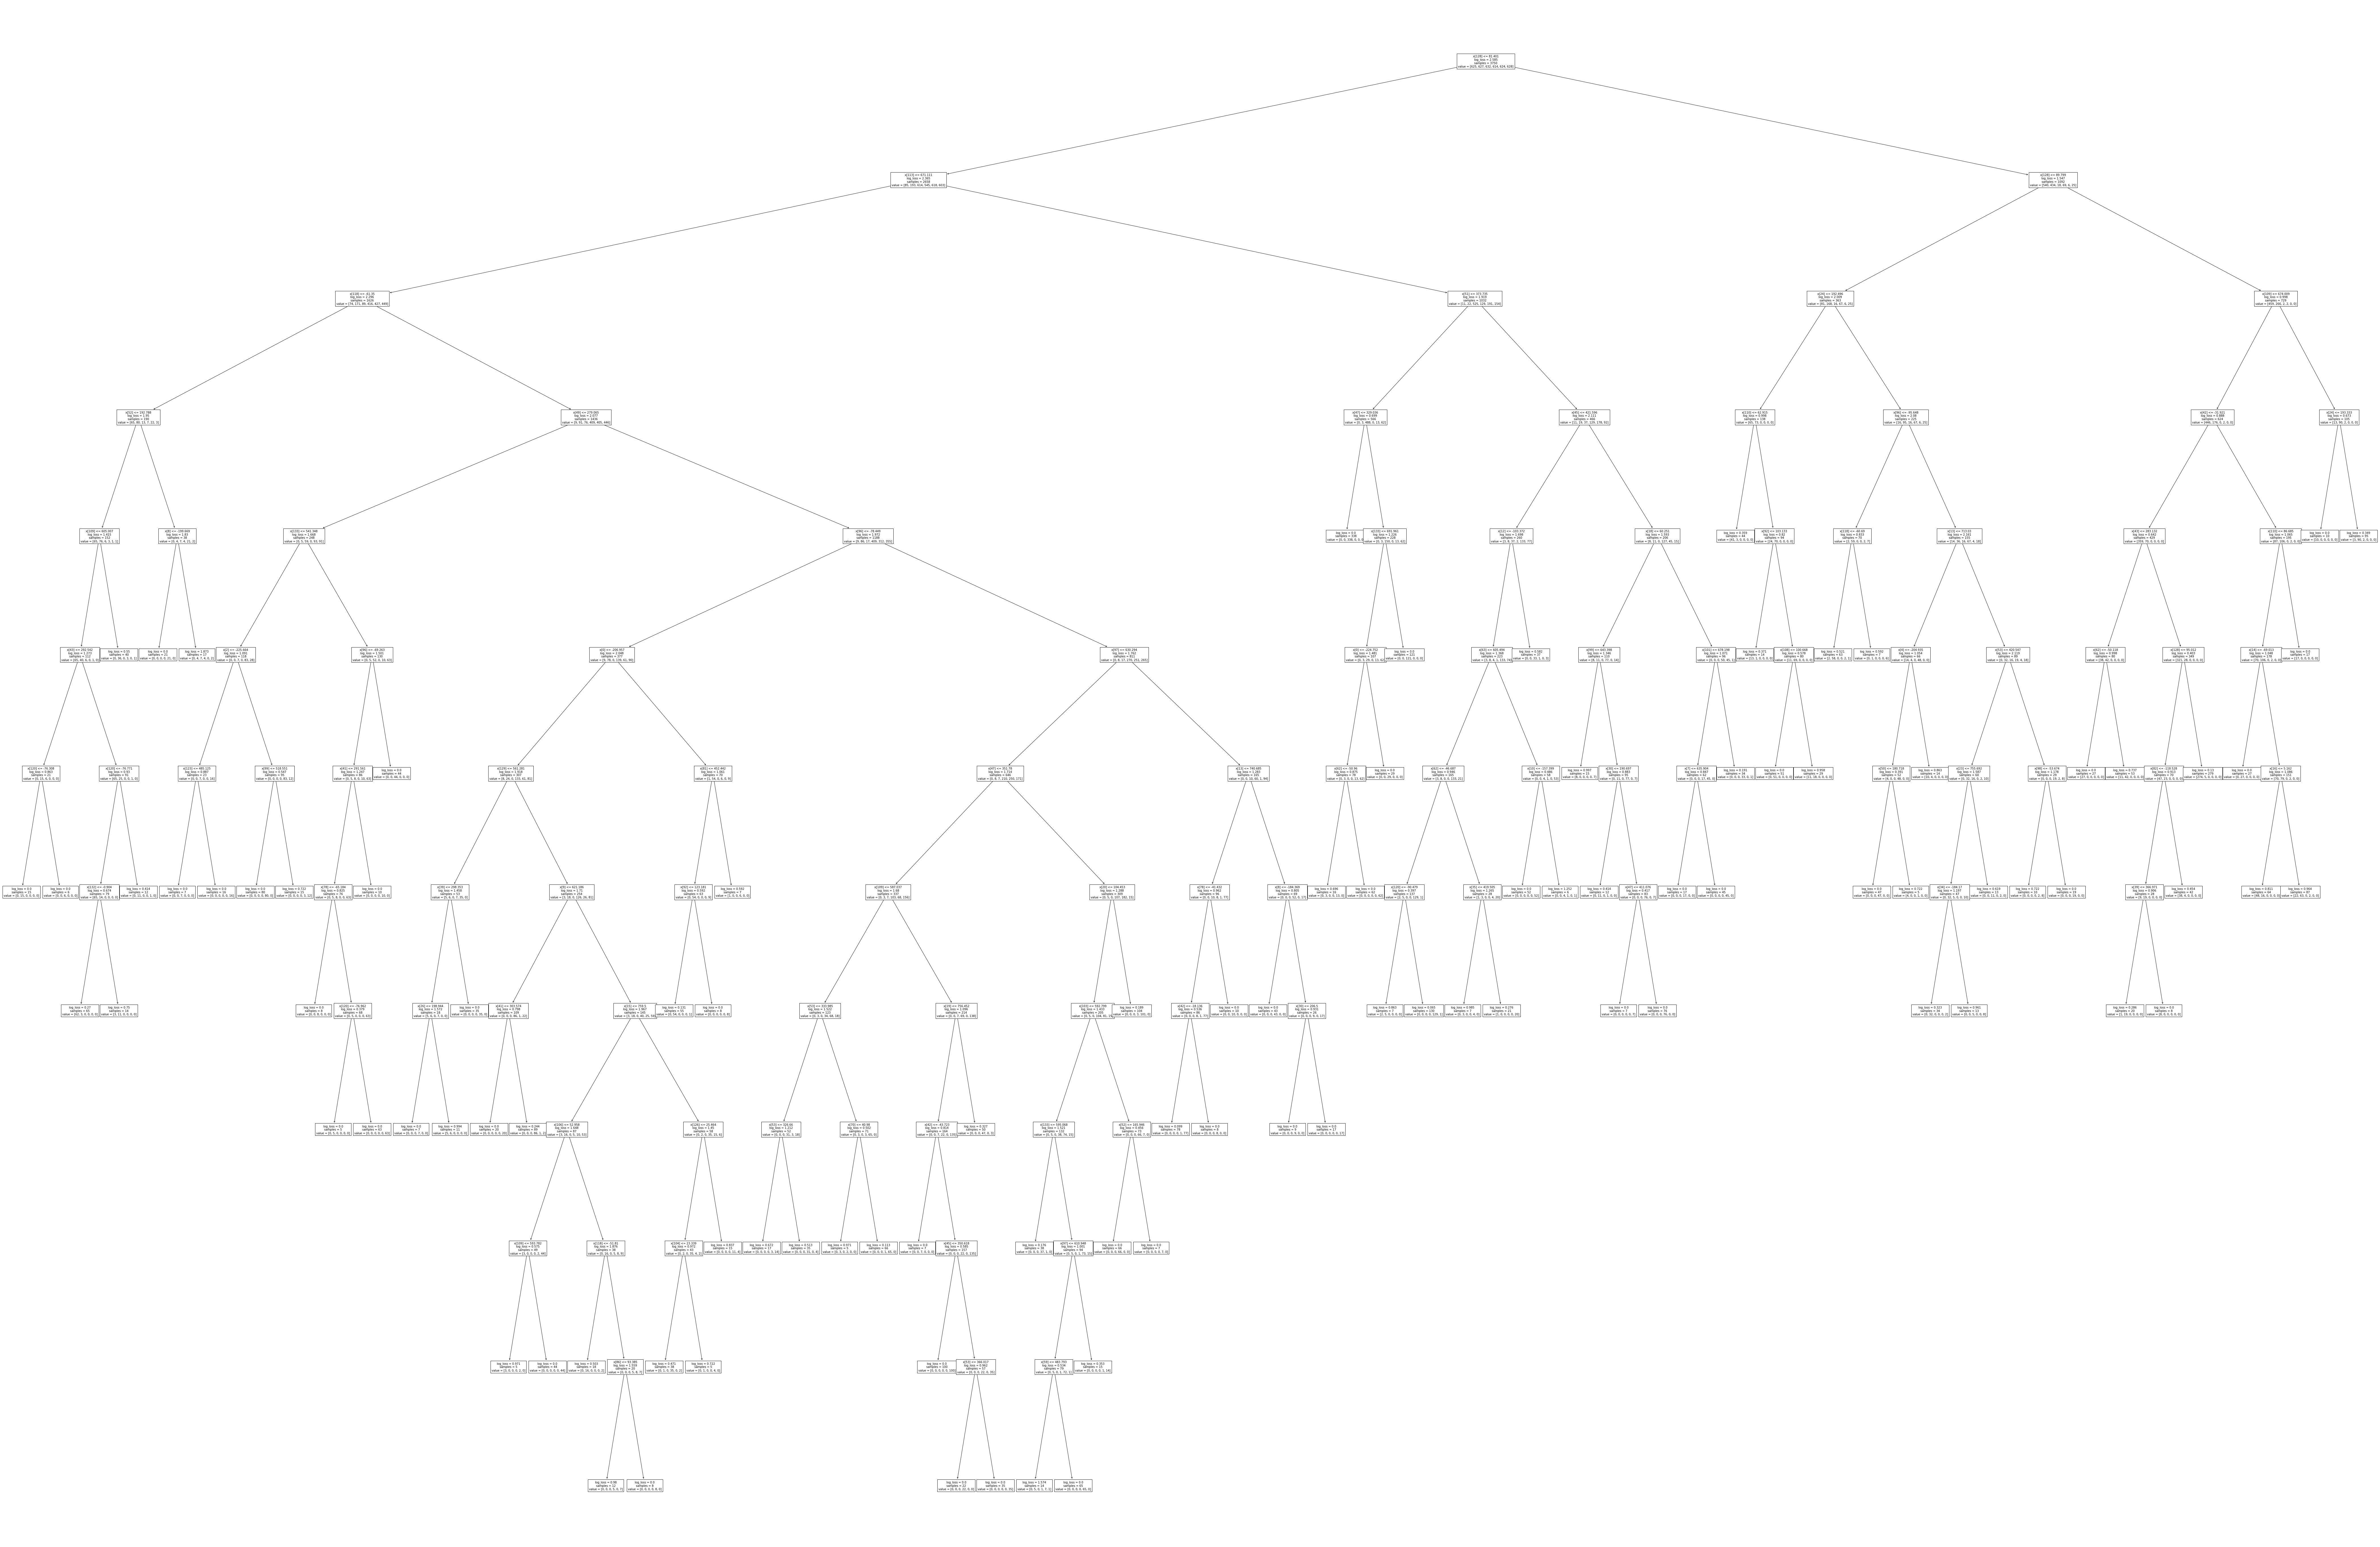

In [15]:
plot_tree(best_tree, fontsize=10)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [72]:
data = load_last_faces(PATH_TO_DATA, PATH_TO_LABEL)
train, test = train_test_split(data)

In [74]:
train = create_data(train, 5000, 5)

In [75]:
train

subject  file           0           1           2           3  \
0       S026   4.0 -205.500000  412.000000 -200.500000  464.000000   
1       S044   5.0 -198.000000  465.000000 -193.000000  512.000000   
2       S109   6.0 -226.000000  398.000000 -223.000000  450.000000   
3       S105   1.0 -221.500000  348.000000 -217.500000  409.000000   
4       S093   1.0 -248.000000  317.000000 -240.000000  378.000000   
...      ...   ...         ...         ...         ...         ...   
4995    S055   4.0 -246.589198  535.621830 -241.769103  582.058971   
4996    S111   7.0 -234.388481  383.470633 -239.665481  441.953459   
4997    S112   5.0 -214.084259  378.434655 -208.366370  440.584090   
4998    S005   1.0 -322.751671  390.920937 -323.251844  467.711327   
4999    S117   6.0 -235.069818  360.182926 -230.131736  429.654532   

               4           5           6           7  ...         127  \
0    -191.500000  513.000000 -178.500000  562.000000  ...  584.000000   
1    -189.000000  559.000000 -181.000000  603.000000  ...  621.000000   
2    -219.000000  502.000000 -211.000000  555.000000  ...  557.000000   
3    -209.500000  468.000000 -198.500000  525.000000  ...  549.000000   
4    -230.000000  435.000000 -217.000000  490.000000  ...  495.000000   
...          ...         ...         ...         ...  ...         ...   
4995 -236.715644  632.346927 -218.108063  686.099441  ...  685.168774   
4996 -231.292906  494.385093 -218.712687  552.628455  ...  548.431868   
4997 -205.108221  498.702294 -194.944209  564.242014  ...  596.018659   
4998 -308.817246  547.332964 -293.889373  621.997215  ...  653.657682   
4999 -219.022665  482.688018 -208.914534  546.657792  ...  575.558851   

            128         129        130         131       132         133  \
0     52.500000  592.000000  18.500000  598.000000 -5.500000  600.000000   
1     44.000000  627.000000  12.000000  620.000000 -3.000000  623.000000   
2     91.000000  560.000000  26.000000  596.000000 -3.000000  600.000000   
3     74.500000  557.000000  21.500000  549.000000 -2.500000  552.000000   
4     64.000000  518.000000  25.000000  511.000000  3.000000  514.000000   
...         ...         ...        ...         ...       ...         ...   
4995  63.073820  687.158531  12.167475  684.892945 -7.250875  689.075071   
4996  66.706394  556.035998  29.204281  558.728733 -4.007054  564.197372   
4997  70.234526  603.805352  19.586858  601.022414 -0.579148  605.551078   
4998  81.704953  668.895105  24.366005  662.143312 -1.601007  666.745081   
4999  71.576522  567.000730  20.598573  569.341944  1.222595  573.796139   

            134         135  emotion  
0    -29.500000  595.000000      5.0  
1    -20.000000  621.000000      4.0  
2    -30.000000  596.000000      1.0  
3    -25.500000  548.000000      6.0  
4    -19.000000  510.000000      6.0  
...         ...         ...      ...  
4995 -21.115306  681.540892      4.0  
4996 -27.584853  557.792640      5.0  
4997 -22.872603  598.498999      4.0  
4998 -39.956621  658.517200      5.0  
4999 -14.149058  567.232086      4.0  

[5000 rows x 139 columns]

In [76]:
train["emotion"].value_counts()

emotion
4.0    834
1.0    834
3.0    834
6.0    834
2.0    834
5.0    830
Name: count, dtype: int64

In [92]:
best_lr.fit(train.loc[:, "0":"135"], train.loc[:, "emotion"])

LogisticRegression(solver='newton-cg')

In [93]:
best_lr.score(test.loc[:, "0":"135"], test.loc[:, "emotion"])

0.8888888888888888

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [80]:
emotions = ["happy", "fear", "surprise", "anger", "disgust", "sadness"]

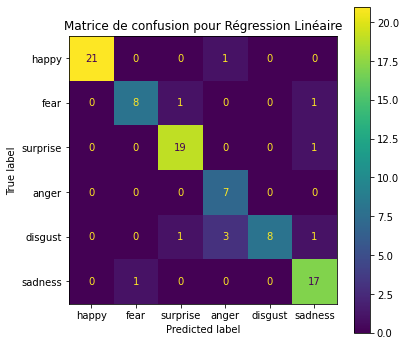

In [94]:
matrix = ConfusionMatrixDisplay(confusion_matrix(test.loc[:, "emotion"], best_lr.predict(test.loc[:, "0":"135"])), display_labels=emotions)
matrix.plot()
matrix.ax_.set_title("Matrice de confusion pour Régression Linéaire")
fig = matrix.ax_.get_figure() 
fig.set_figwidth(6)
fig.set_figheight(6) 

In [82]:
best_tree.fit(train.loc[:, "0":"135"], train.loc[:, "emotion"])
best_tree.score(test.loc[:, "0":"135"], test.loc[:, "emotion"])

0.5444444444444444

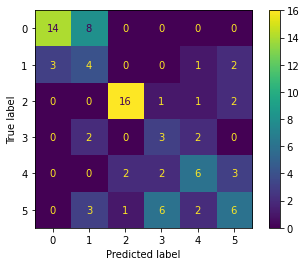

In [83]:
ConfusionMatrixDisplay(confusion_matrix(test.loc[:, "emotion"], best_tree.predict(test.loc[:, "0":"135"]))).plot()

In [84]:
best_mlp.fit(train.loc[:, "0":"135"], train.loc[:, "emotion"])
best_mlp.score(test.loc[:, "0":"135"], test.loc[:, "emotion"])

0.7111111111111111

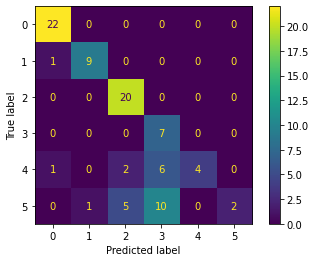

In [85]:
ConfusionMatrixDisplay(confusion_matrix(test.loc[:, "emotion"], best_mlp.predict(test.loc[:, "0":"135"]))).plot()

In [8]:
local_data = load_last_faces(PATH_TO_DATA, PATH_TO_LABEL)

In [42]:
from sklearn.svm import SVC

In [43]:
model = SVC(C=0.01, kernel="linear")

In [48]:
scores = {}

In [49]:
for max_data in tqdm([3000, 4000, 5000, 6000, 7000][::-1]):
    if max_data not in scores:
        scores[max_data] = {}

    for randomness in range(3, 22, 3):
        train, test = train_test_split(local_data)
        train = create_data(train, max_data, randomness)

        cross_val_score_2 = cross_val_score(model, train.loc[:, "0":"135"], train["emotion"]).mean()

        model.fit(train.loc[:, "0":"135"], train["emotion"])

        scores[max_data][randomness] = {
                "cross_val_score": round(cross_val_score_2, 3),
                "score": round(model.score(test.loc[:, "0":"135"], test["emotion"]), 3)
        }
        print(randomness)


  0%|          | 0/5 [00:00<?, ?it/s]

3
6
9
12
15
18


 20%|██        | 1/5 [59:29<3:57:59, 3569.87s/it]

21
3
6
9
12
15
18


 40%|████      | 2/5 [1:23:28<1:55:48, 2316.33s/it]

21
3
6
9
12
15
18


 60%|██████    | 3/5 [1:42:49<59:37, 1788.89s/it]  

21
3
6
9
12
15
18


 80%|████████  | 4/5 [1:57:12<23:43, 1423.06s/it]

21
3
6
9
12
15
18


100%|██████████| 5/5 [2:07:26<00:00, 1529.39s/it]

21


In [50]:
scores

{7000: {3: {'cross_val_score': 1.0, 'score': 0.867},
  6: {'cross_val_score': 0.982, 'score': 0.889},
  9: {'cross_val_score': 0.952, 'score': 0.822},
  12: {'cross_val_score': 0.926, 'score': 0.889},
  15: {'cross_val_score': 0.876, 'score': 0.889},
  18: {'cross_val_score': 0.86, 'score': 0.844},
  21: {'cross_val_score': 0.825, 'score': 0.878}},
 6000: {3: {'cross_val_score': 1.0, 'score': 0.878},
  6: {'cross_val_score': 0.989, 'score': 0.889},
  9: {'cross_val_score': 0.961, 'score': 0.867},
  12: {'cross_val_score': 0.923, 'score': 0.867},
  15: {'cross_val_score': 0.898, 'score': 0.811},
  18: {'cross_val_score': 0.855, 'score': 0.833},
  21: {'cross_val_score': 0.835, 'score': 0.856}},
 5000: {3: {'cross_val_score': 1.0, 'score': 0.822},
  6: {'cross_val_score': 0.987, 'score': 0.878},
  9: {'cross_val_score': 0.949, 'score': 0.878},
  12: {'cross_val_score': 0.896, 'score': 0.889},
  15: {'cross_val_score': 0.886, 'score': 0.833},
  18: {'cross_val_score': 0.844, 'score': 0.84

In [29]:
for depth in scores:
    for randomness in scores[depth]:
        for model in scores[depth][randomness]:
            for method in scores[depth][randomness][model]:
                scores[depth][randomness][model][method] = round(scores[depth][randomness][model][method], 3)

In [31]:
pprint(scores)

{500: {2: {1: {'cross_val_score': 0.96, 'score': 0.833},
           2: {'cross_val_score': 0.98, 'score': 0.844}},
       4: {1: {'cross_val_score': 0.954, 'score': 0.811},
           2: {'cross_val_score': 0.974, 'score': 0.844}},
       6: {1: {'cross_val_score': 0.922, 'score': 0.856},
           2: {'cross_val_score': 0.964, 'score': 0.867}},
       8: {1: {'cross_val_score': 0.906, 'score': 0.867},
           2: {'cross_val_score': 0.928, 'score': 0.867}},
       10: {1: {'cross_val_score': 0.86, 'score': 0.878},
            2: {'cross_val_score': 0.908, 'score': 0.878}}},
 1000: {2: {1: {'cross_val_score': 0.994, 'score': 0.878},
            2: {'cross_val_score': 0.998, 'score': 0.878}},
        4: {1: {'cross_val_score': 0.982, 'score': 0.867},
            2: {'cross_val_score': 0.991, 'score': 0.889}},
        6: {1: {'cross_val_score': 0.95, 'score': 0.867},
            2: {'cross_val_score': 0.969, 'score': 0.878}},
        8: {1: {'cross_val_score': 0.928, 'score': 0.933},


In [33]:
scores[2000][10], scores[1000][8]

({1: {'cross_val_score': 0.924, 'score': 0.922},
  2: {'cross_val_score': 0.906, 'score': 0.933}},
 {1: {'cross_val_score': 0.928, 'score': 0.933},
  2: {'cross_val_score': 0.947, 'score': 0.922}})